# MODELIZATION

## Objective :
- Build a first model with the original data
- Correct the Overfitting problem with balanced class weights
- Correct the Overfitting problem with the SMOTE method
- Choose the most efficient model to use for the optimization stage: the metric to observe is Recall (Sensitivity) because the goal of our project is to minimize false negatives, given that each customer who refuses the offer has a high cost for the company which has invested a lot of resources to put this product on the market.

In [2]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning


from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

import pickle

In [3]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [4]:
# Load the preprocessed DataFrame
df = pd.read_pickle('processed_data.pkl')

df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,0,0,0,1,0,0,2,1,4,0,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,0,0,2,1,0,2,2,2,5,1,147.25,39.0,106.0,78.0,366.0
2,3,No,0,1,0,2,0,2,2,1,2,1,276.50,367.0,352.0,145.0,242.0
3,4,No,0,0,2,2,0,0,1,1,4,0,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,0,0,2,1,0,2,2,1,6,1,1211.00,2140.0,1357.0,982.0,365.0


In [5]:
#Split data into X (features) and y (label)

X = df.drop(columns=['Offer Accepted', 'Customer Number'])
y = df['Offer Accepted'].apply(lambda x: 1 if x == 'Yes' else 0)

In [6]:
#Split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Normalize numerical variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Vesion 1: Basic model

In [8]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(random_state=0, probability=True)),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
}

# Dictionary to store performance metrics
performance_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': []
}

def evaluation(model):
    # Train the model
    result = model.fit(X_train, y_train)
    y_pred = result.predict(X_test)
    
    # Display model scores
    train_score = result.score(X_train, y_train)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)

    # Display confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Compute learning curves with recall for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='recall', train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(N, train_score.mean(axis=1), label='Train Recall')
    plt.plot(N, val_score.mean(axis=1), label='Validation Recall')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Recall')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute ROC AUC score and plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Add performance metrics to the summary
    performance_summary['Model'].append(model.__class__.__name__)
    performance_summary['Accuracy'].append(accuracy)
    performance_summary['Precision'].append(precision)
    performance_summary['Recall'].append(recall)
    performance_summary['F1 Score'].append(f1)
    performance_summary['AUC'].append(roc_auc)

Logistic Regression
Train Score: 0.9422809457579973
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



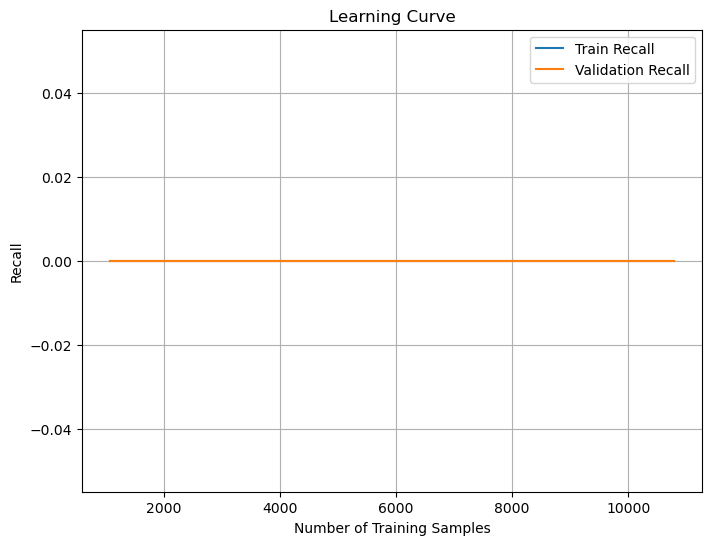

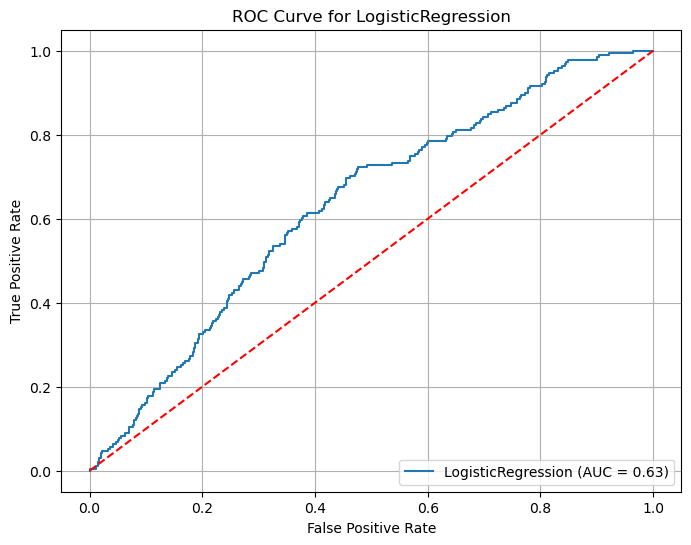

Decision Tree
Train Score: 1.0
Test Score: 0.8943270300333704
Confusion Matrix:
 [[3190  215]
 [ 165   26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      3405
           1       0.11      0.14      0.12       191

    accuracy                           0.89      3596
   macro avg       0.53      0.54      0.53      3596
weighted avg       0.91      0.89      0.90      3596



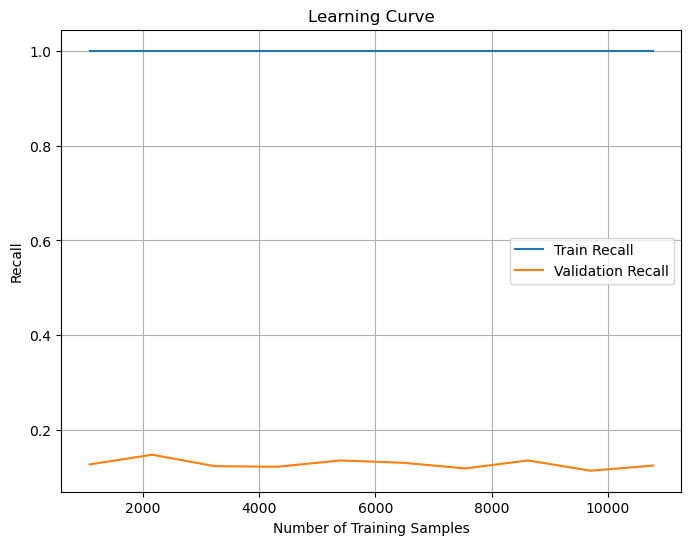

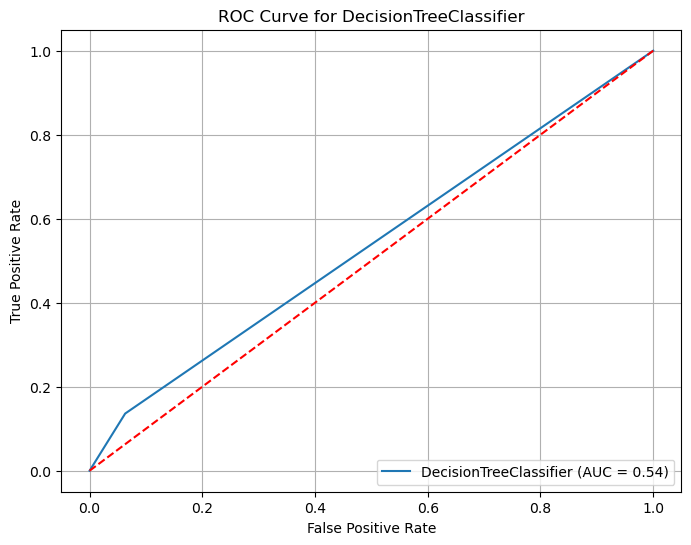

Random Forest
Train Score: 1.0
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



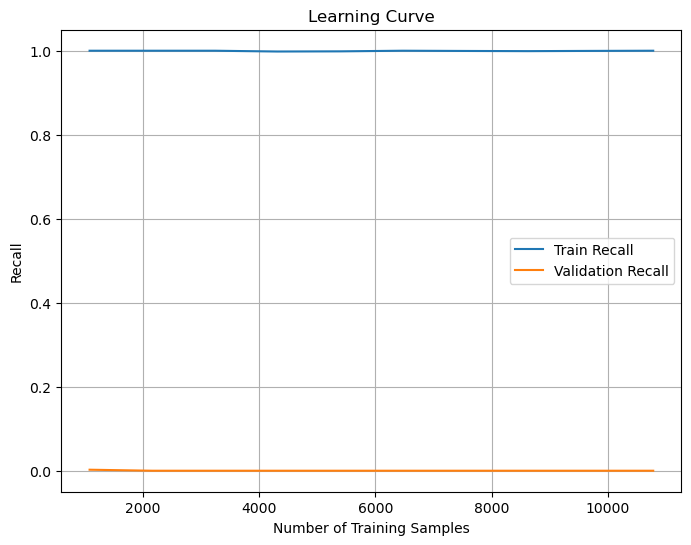

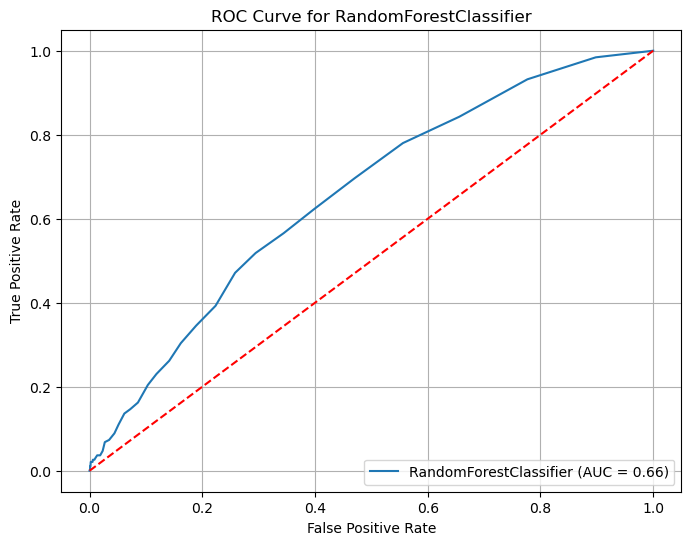

AdaBoost


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Score: 0.9422809457579973
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

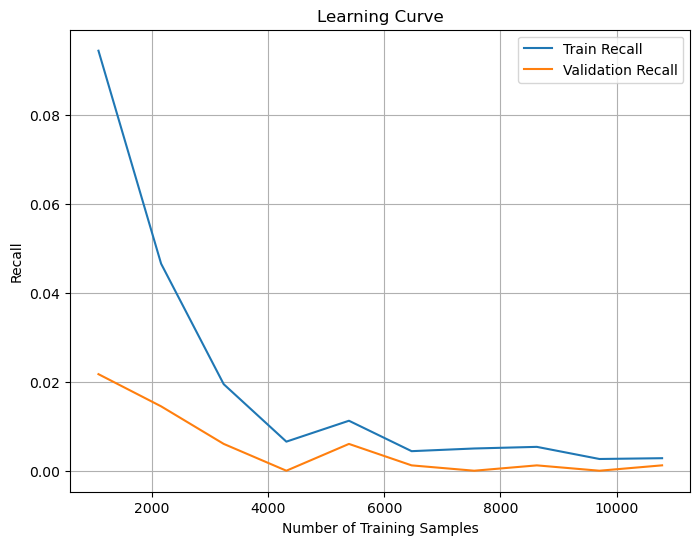

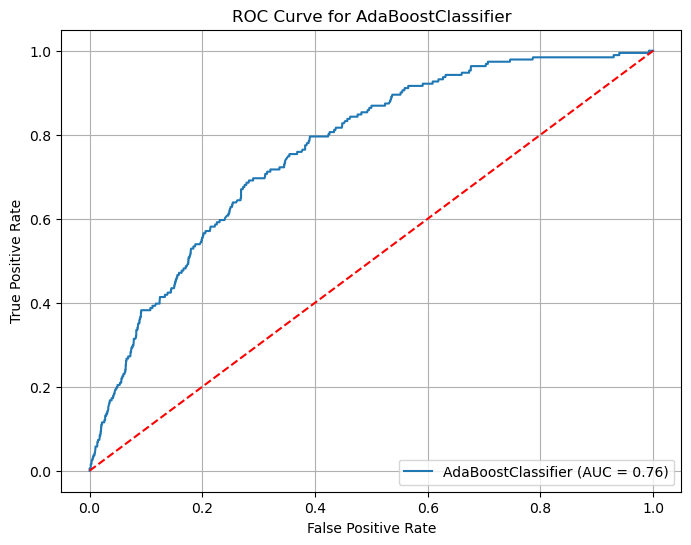

Support Vector Machine
Train Score: 0.9422809457579973
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



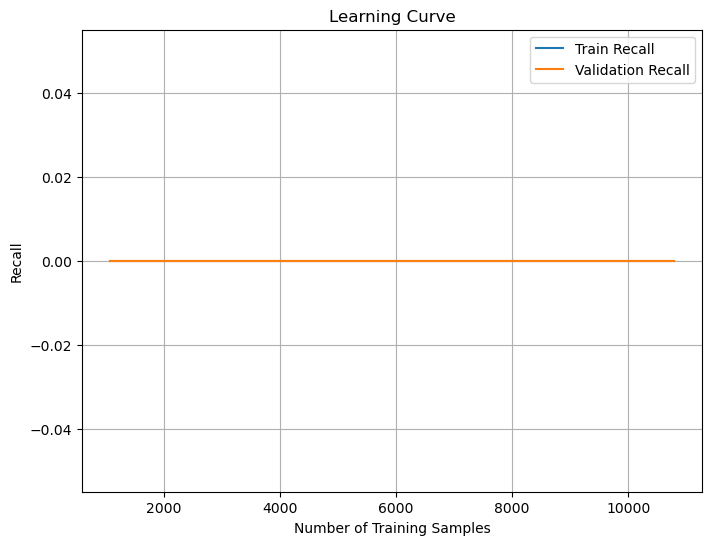

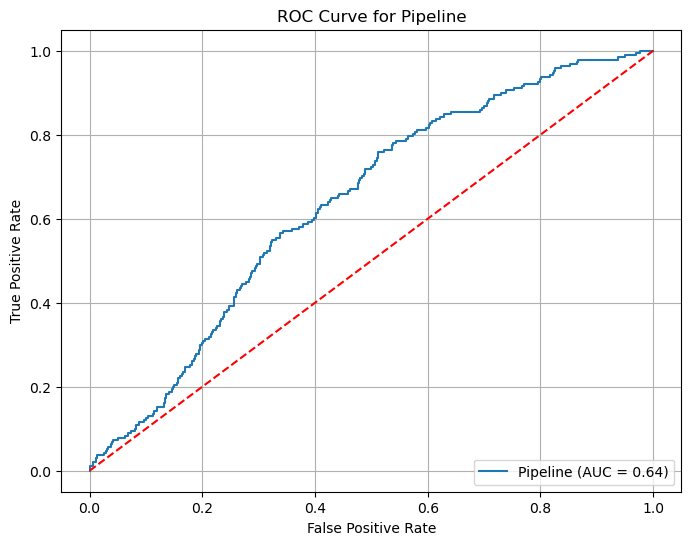

K-Nearest Neighbors
Train Score: 0.9438108484005563
Test Score: 0.942714126807564
Confusion Matrix:
 [[3389   16]
 [ 190    1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.06      0.01      0.01       191

    accuracy                           0.94      3596
   macro avg       0.50      0.50      0.49      3596
weighted avg       0.90      0.94      0.92      3596



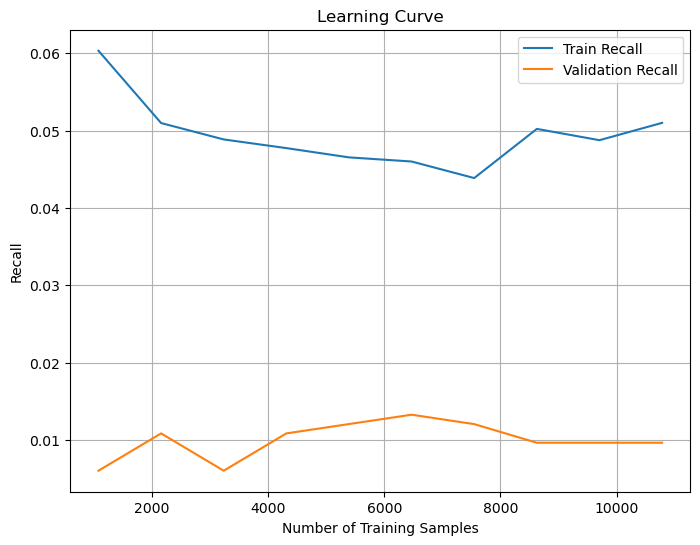

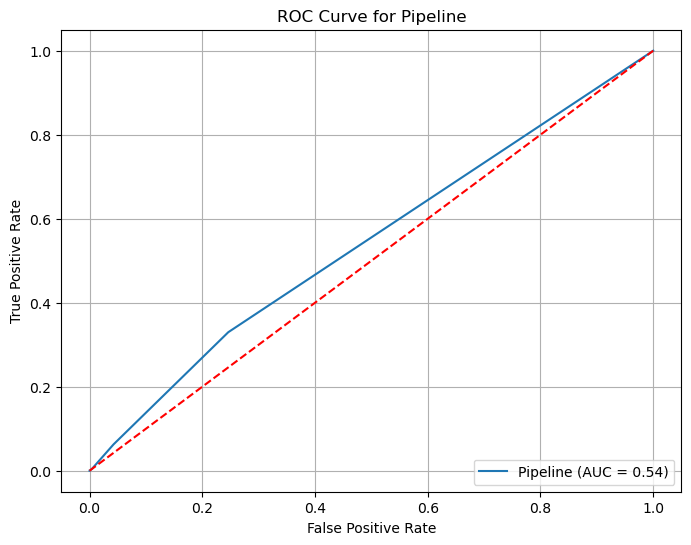

LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 830, number of negative: 13550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 14380, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057719 -> initscore=-2.792716
[LightGBM] [Info] Start training from score -2.792716
Train Score: 0.9496522948539639
Test Score: 0.946329254727475
Confusion Matrix:
 [[3403    2]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   ma

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 269, number of negative: 4045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062355 -> initscore=-2.710525
[LightGBM] [Info] Start training from score -2.710525
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 330, number of negative: 5062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Numb

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 510, number of negative: 8118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 8628, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059110 -> initscore=-2.767428
[LightGBM] [Info] Start training from score -2.767428
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 569, number of negative: 9137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

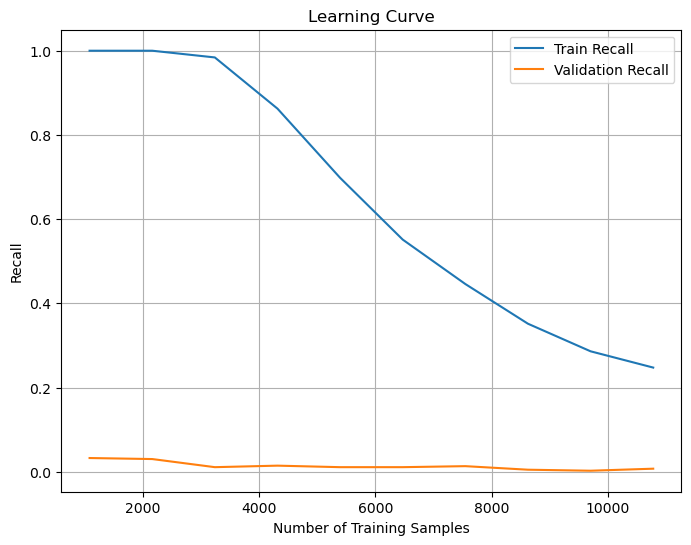

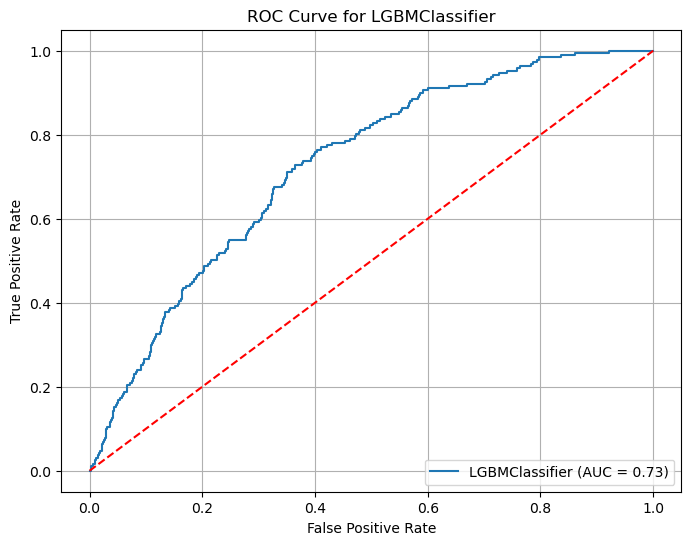

CatBoost
Train Score: 0.949721835883171
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



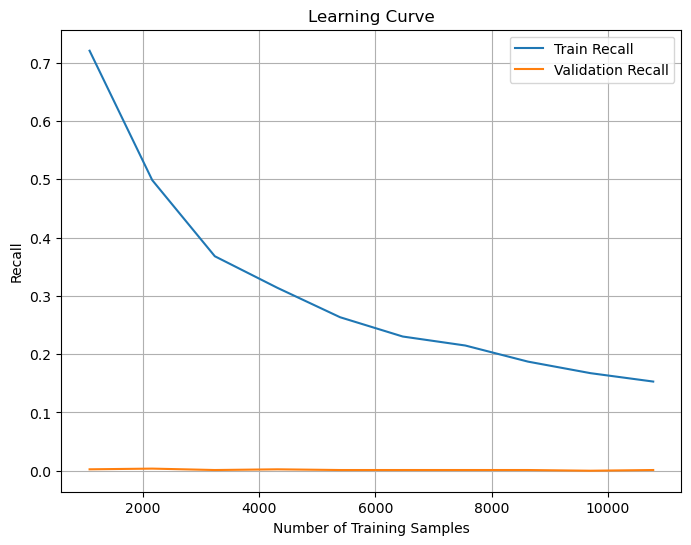

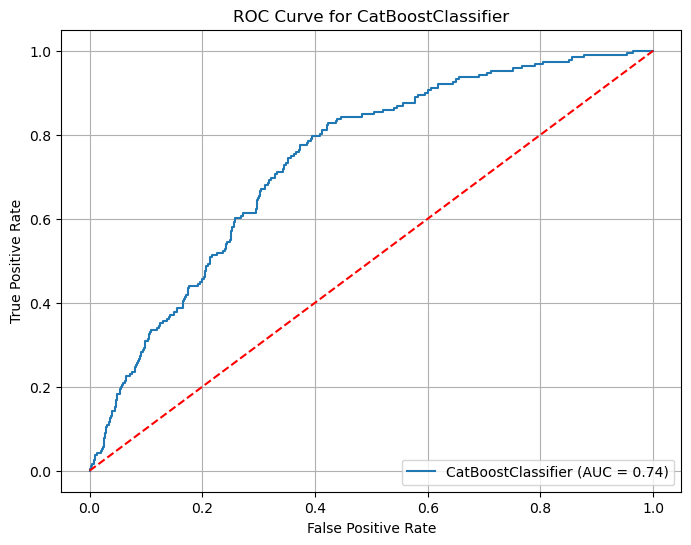

XGBoost
Train Score: 0.9648817802503477
Test Score: 0.8826473859844272
Confusion Matrix:
 [[3137  268]
 [ 154   37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      3405
           1       0.12      0.19      0.15       191

    accuracy                           0.88      3596
   macro avg       0.54      0.56      0.54      3596
weighted avg       0.91      0.88      0.90      3596



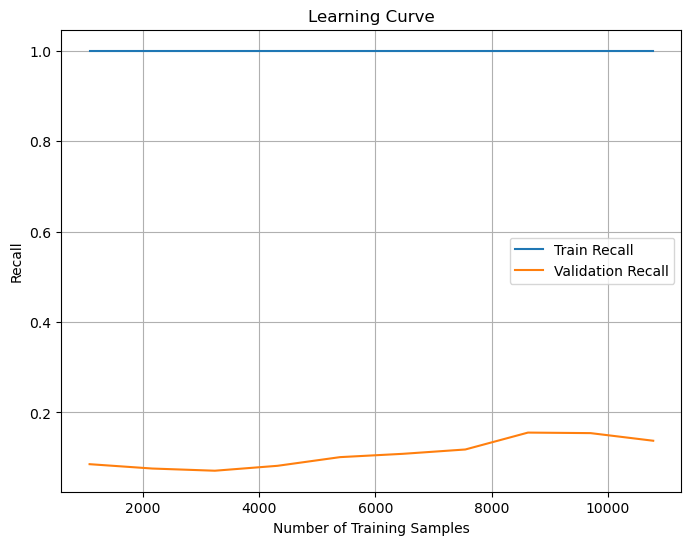

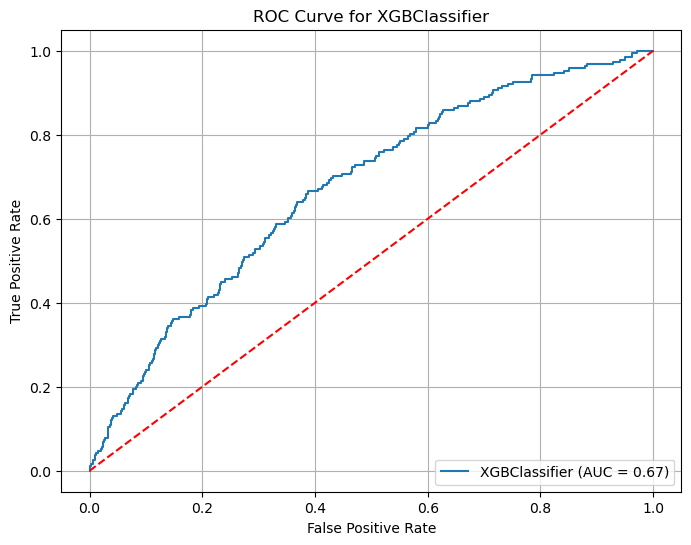

In [9]:
# Evaluate each model
for name, model in models.items():
    print(name)
    evaluation(model)

In [10]:
# Create a DataFrame with the results
performance_df = pd.DataFrame(performance_summary)

# Display the performance summary
print(performance_df)

                    Model  Accuracy  Precision    Recall  F1 Score       AUC
0      LogisticRegression  0.946885   0.000000  0.000000  0.000000  0.633306
1  DecisionTreeClassifier  0.894327   0.107884  0.136126  0.120370  0.536492
2  RandomForestClassifier  0.946885   0.000000  0.000000  0.000000  0.655731
3      AdaBoostClassifier  0.946885   0.000000  0.000000  0.000000  0.764458
4                Pipeline  0.946885   0.000000  0.000000  0.000000  0.637327
5                Pipeline  0.942714   0.058824  0.005236  0.009615  0.542538
6          LGBMClassifier  0.946329   0.000000  0.000000  0.000000  0.726162
7      CatBoostClassifier  0.946885   0.000000  0.000000  0.000000  0.739049
8           XGBClassifier  0.882647   0.121311  0.193717  0.149194  0.673246


# Vesion 2: Basic model initialized with balanced class weights

In [11]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(random_state=0, probability=True, class_weight='balanced')),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
}

# Dictionary to store performance metrics
performance_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': []
}

def evaluation(model):
    # Train the model
    result = model.fit(X_train, y_train)
    y_pred = result.predict(X_test)
    
    # Display model scores
    train_score = result.score(X_train, y_train)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)

    # Display confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Compute learning curves with recall for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='recall', train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(N, train_score.mean(axis=1), label='Train Recall')
    plt.plot(N, val_score.mean(axis=1), label='Validation Recall')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Recall')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute ROC AUC score and plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Add performance metrics to the summary
    performance_summary['Model'].append(model.__class__.__name__)
    performance_summary['Accuracy'].append(accuracy)
    performance_summary['Precision'].append(precision)
    performance_summary['Recall'].append(recall)
    performance_summary['F1 Score'].append(f1)
    performance_summary['AUC'].append(roc_auc)

Logistic Regression
Train Score: 0.5914464534075105
Test Score: 0.5862068965517241
Confusion Matrix:
 [[1983 1422]
 [  66  125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.58      0.73      3405
           1       0.08      0.65      0.14       191

    accuracy                           0.59      3596
   macro avg       0.52      0.62      0.44      3596
weighted avg       0.92      0.59      0.70      3596



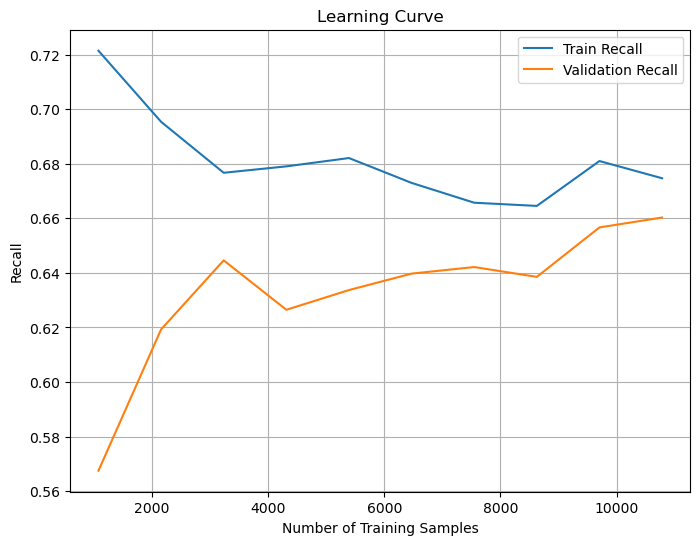

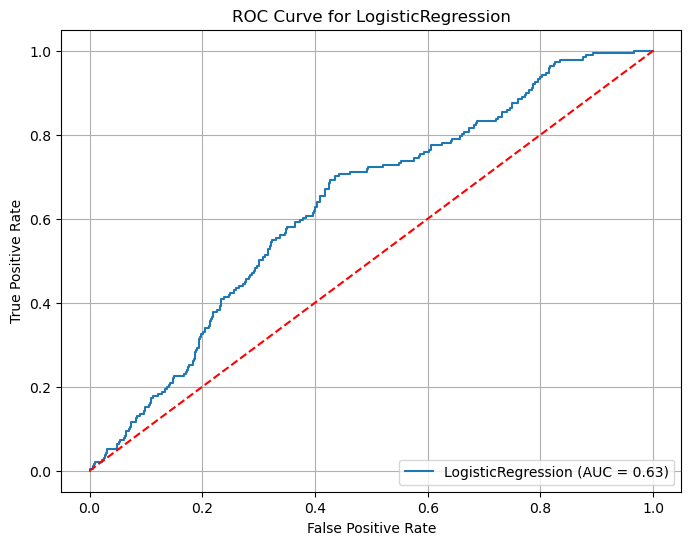

Decision Tree
Train Score: 1.0
Test Score: 0.8923804226918799
Confusion Matrix:
 [[3194  211]
 [ 176   15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      3405
           1       0.07      0.08      0.07       191

    accuracy                           0.89      3596
   macro avg       0.51      0.51      0.51      3596
weighted avg       0.90      0.89      0.90      3596



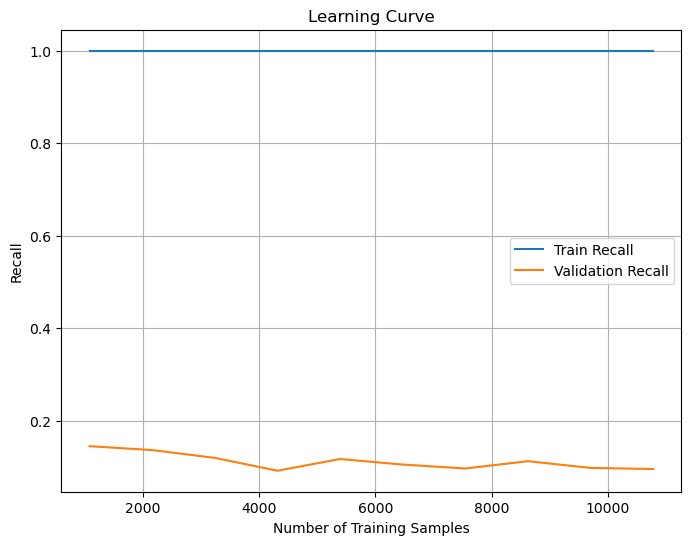

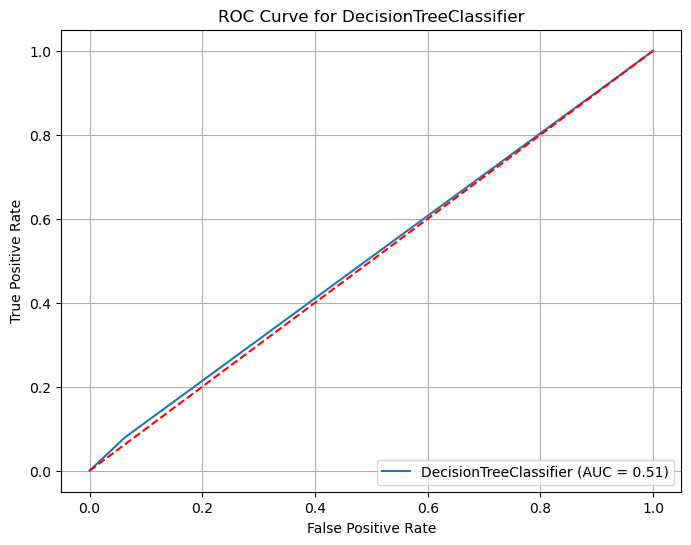

Random Forest
Train Score: 1.0
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



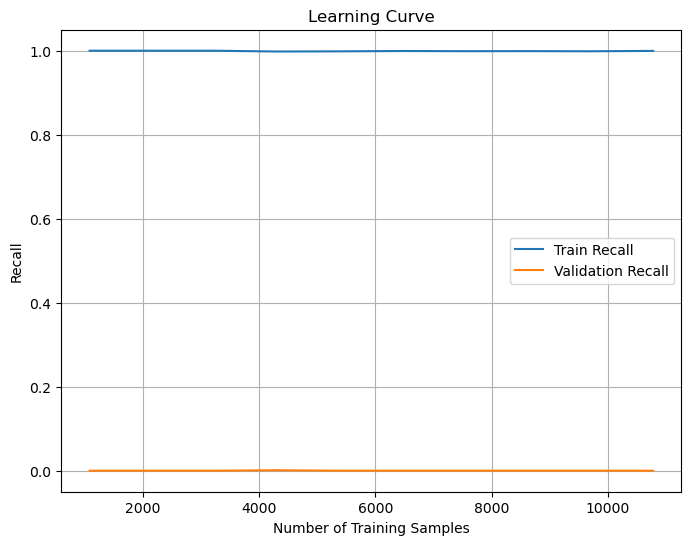

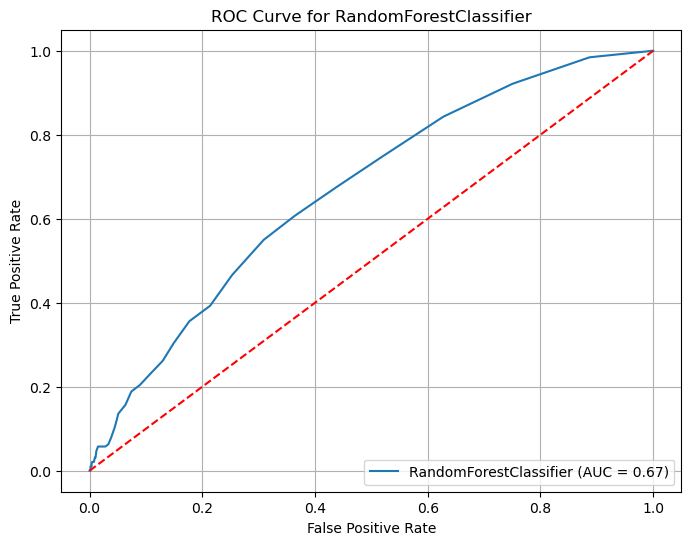

AdaBoost


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Score: 0.9422809457579973
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

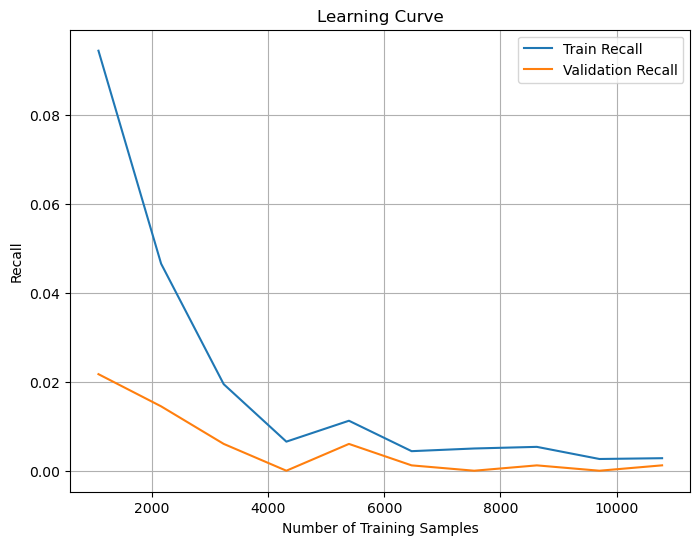

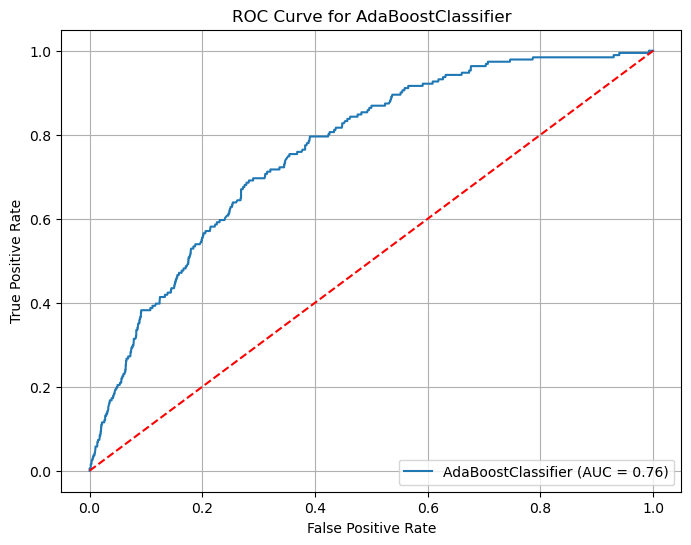

Support Vector Machine
Train Score: 0.7428372739916551
Test Score: 0.6952169076751946
Confusion Matrix:
 [[2383 1022]
 [  74  117]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81      3405
           1       0.10      0.61      0.18       191

    accuracy                           0.70      3596
   macro avg       0.54      0.66      0.49      3596
weighted avg       0.92      0.70      0.78      3596



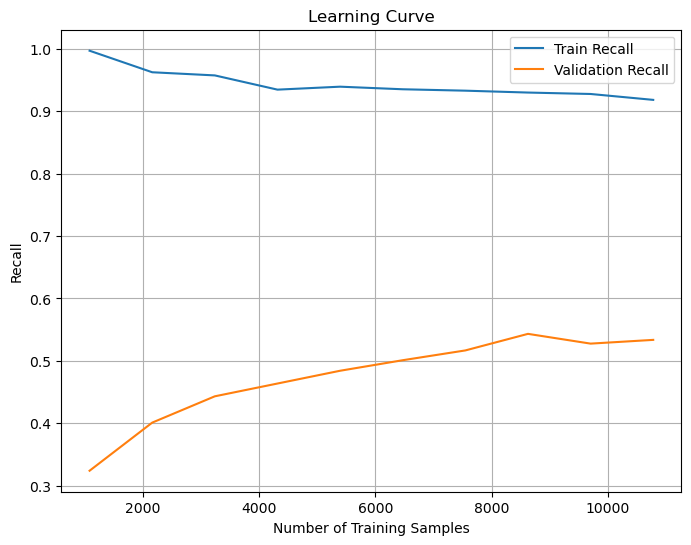

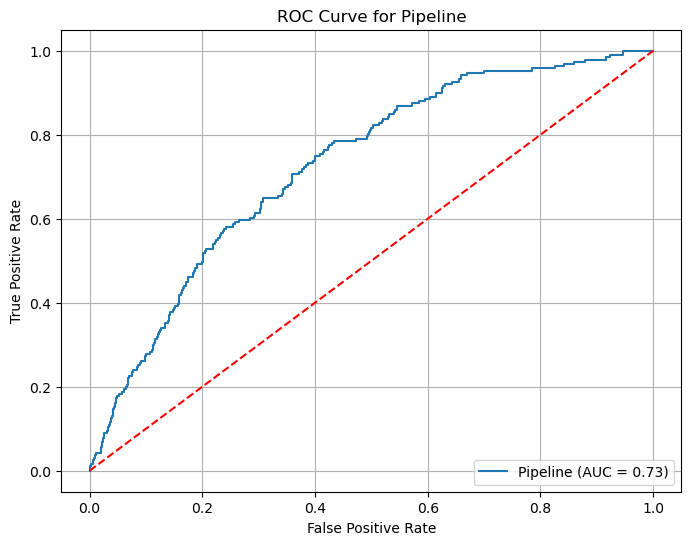

K-Nearest Neighbors
Train Score: 0.9438108484005563
Test Score: 0.942714126807564
Confusion Matrix:
 [[3389   16]
 [ 190    1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.06      0.01      0.01       191

    accuracy                           0.94      3596
   macro avg       0.50      0.50      0.49      3596
weighted avg       0.90      0.94      0.92      3596



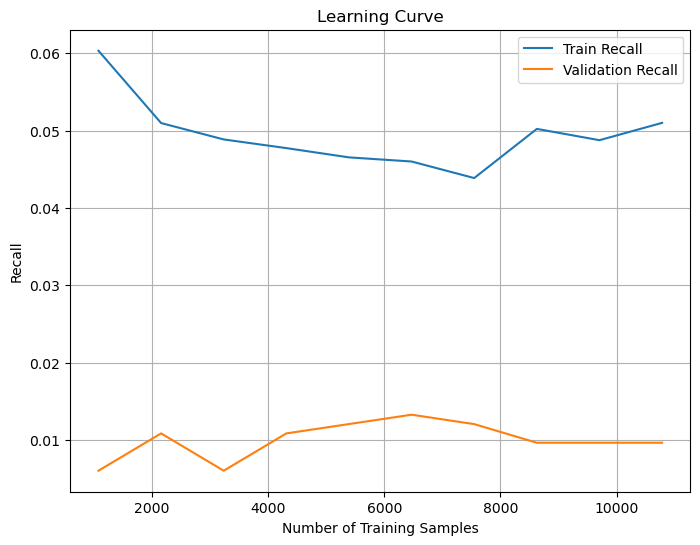

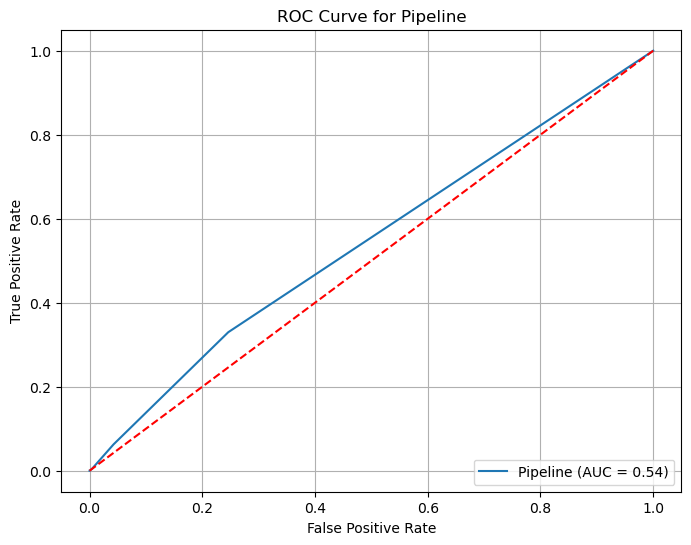

LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 830, number of negative: 13550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 14380, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Train Score: 0.8559805285118219
Test Score: 0.7958843159065628
Confusion Matrix:
 [[2770  635]
 [  99   92]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88      3405
           1       0.13      0.48      0.20       191

    accuracy                           0.80      3596
   mac

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 269, number of negative: 4045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 330, number of negative: 5062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 510, number of negative: 8118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 8628, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 569, number of negative: 9137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

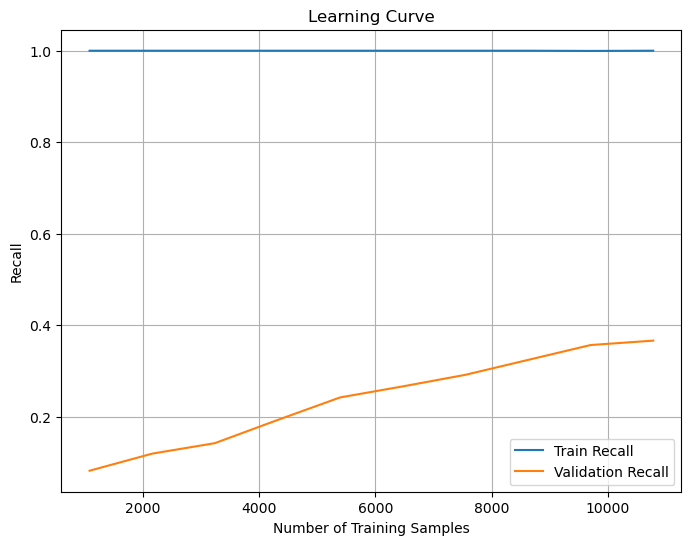

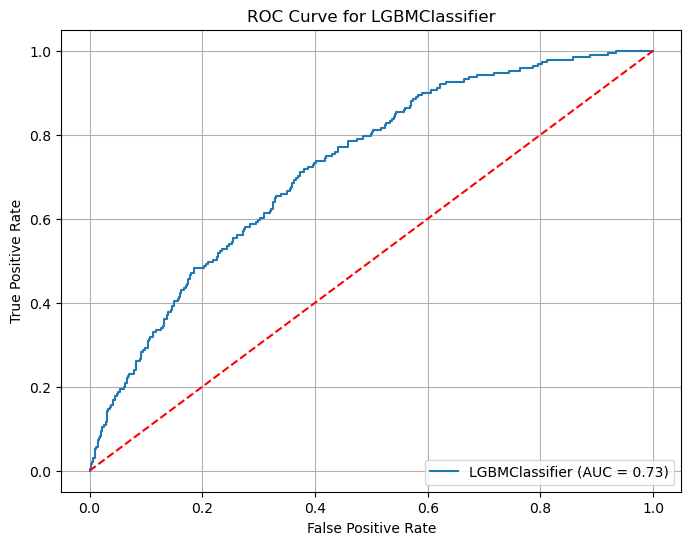

CatBoost
Train Score: 0.949721835883171
Test Score: 0.9468854282536151
Confusion Matrix:
 [[3405    0]
 [ 191    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



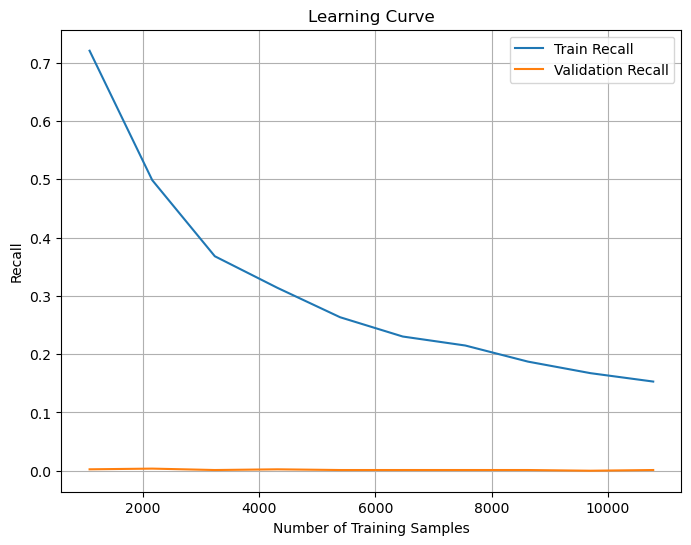

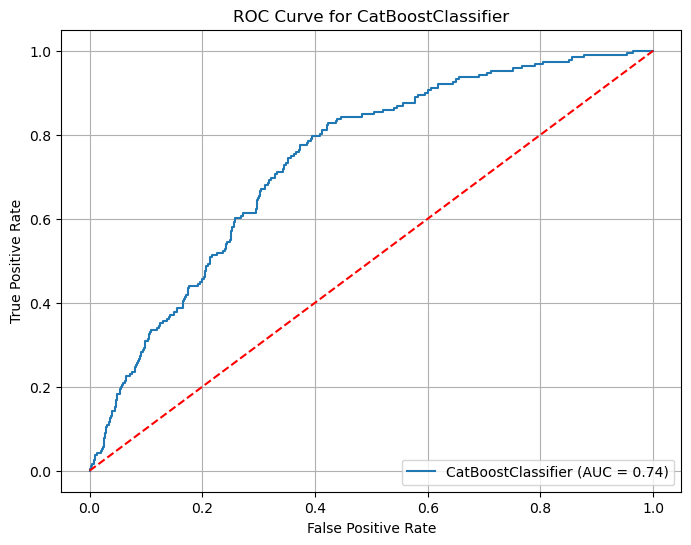

XGBoost
Train Score: 0.9648817802503477
Test Score: 0.8826473859844272
Confusion Matrix:
 [[3137  268]
 [ 154   37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      3405
           1       0.12      0.19      0.15       191

    accuracy                           0.88      3596
   macro avg       0.54      0.56      0.54      3596
weighted avg       0.91      0.88      0.90      3596



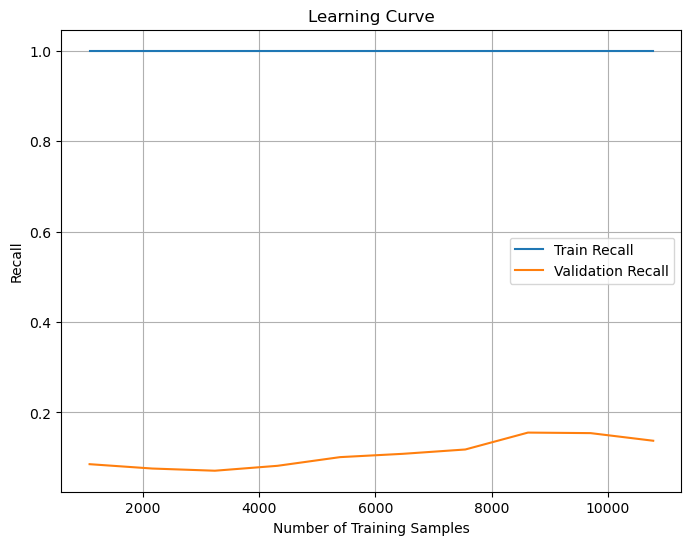

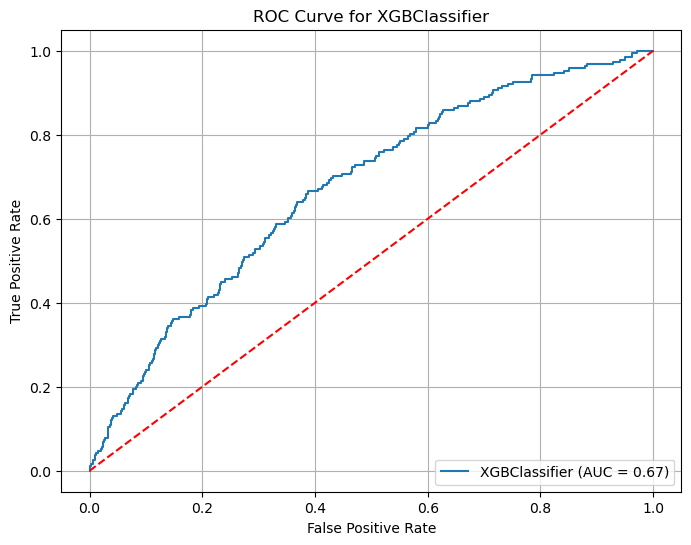

In [12]:
# Evaluate each model
for name, model in models.items():
    print(name)
    evaluation(model)

In [13]:
# Create a DataFrame with the results
performance_df = pd.DataFrame(performance_summary)

# Display the performance summary
print(performance_df)

                    Model  Accuracy  Precision    Recall  F1 Score       AUC
0      LogisticRegression  0.586207   0.080802  0.654450  0.143843  0.633640
1  DecisionTreeClassifier  0.892380   0.066372  0.078534  0.071942  0.508283
2  RandomForestClassifier  0.946885   0.000000  0.000000  0.000000  0.666795
3      AdaBoostClassifier  0.946885   0.000000  0.000000  0.000000  0.764458
4                Pipeline  0.695217   0.102722  0.612565  0.175940  0.727183
5                Pipeline  0.942714   0.058824  0.005236  0.009615  0.542538
6          LGBMClassifier  0.795884   0.126547  0.481675  0.200436  0.725046
7      CatBoostClassifier  0.946885   0.000000  0.000000  0.000000  0.739049
8           XGBClassifier  0.882647   0.121311  0.193717  0.149194  0.673246


# Vesion 3: Basic model with the SMOTE method and unbalanced classes

### Let's balance our dataset with the Smote method

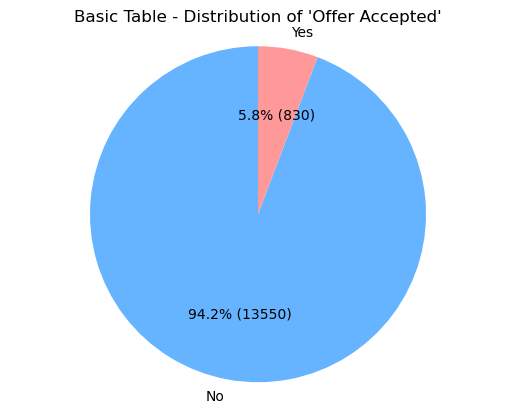

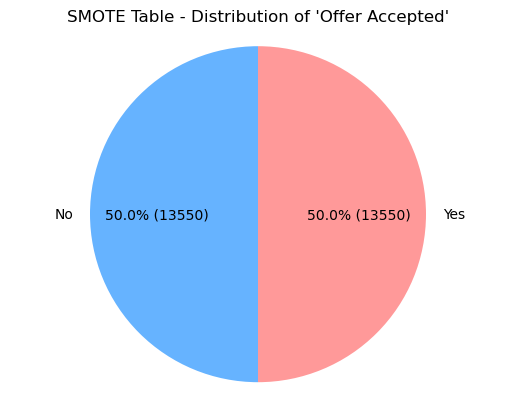

In [14]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Create a new DataFrame with the sampled data
df_smote = pd.concat([X_train_smote, y_train_smote], axis=1)

# Function to create a pie chart with proportions and numbers
def plot_pie_chart(y, title):
    labels = ['No', 'Yes']
    sizes = y.value_counts().values
    colors = ['#66b3ff', '#ff9999']
    
    # Modify the format of the labels to include proportions and numbers
    def autopct_format(pct, all_values):
        absolute = int(round(pct / 100 * sum(all_values)))
        return f"{pct:.1f}% ({absolute})"

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: autopct_format(pct, sizes), startangle=90)
    ax.axis('equal')  
    plt.title(title)
    plt.show()

# Create a pie chart for the basic table
plot_pie_chart(y_train, "Basic Table - Distribution of 'Offer Accepted'")

# Create a pie chart for the oversampled table
plot_pie_chart(y_train_smote, "SMOTE Table - Distribution of 'Offer Accepted'")


In [15]:


# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(random_state=0)),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Dictionary to store performance metrics
performance_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': []
}

def evaluation(model):
    result = model.fit(X_train_smote, y_train_smote)
    y_pred = result.predict(X_test)
    
    # Display model scores
    train_score = result.score(X_train_smote, y_train_smote)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)

    # Display confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Compute learning curves with recall for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train_smote, y_train_smote, cv=4, scoring='recall', train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(N, train_score.mean(axis=1), label='Train Recall')
    plt.plot(N, val_score.mean(axis=1), label='Validation Recall')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Recall')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute ROC AUC score and plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Add performance metrics to the summary
    performance_summary['Model'].append(model.__class__.__name__)
    performance_summary['Accuracy'].append(accuracy)
    performance_summary['Precision'].append(precision)
    performance_summary['Recall'].append(recall)
    performance_summary['F1 Score'].append(f1)
    performance_summary['AUC'].append(roc_auc)

Logistic Regression
Train Score: 0.6248708487084871
Test Score: 0.560622914349277
Confusion Matrix:
 [[1911 1494]
 [  86  105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.56      0.71      3405
           1       0.07      0.55      0.12       191

    accuracy                           0.56      3596
   macro avg       0.51      0.56      0.41      3596
weighted avg       0.91      0.56      0.68      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1246, in fit
    raise ValueE

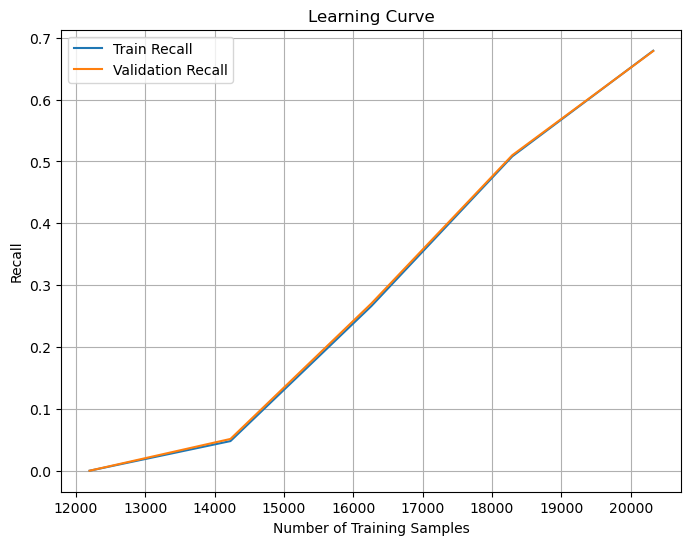

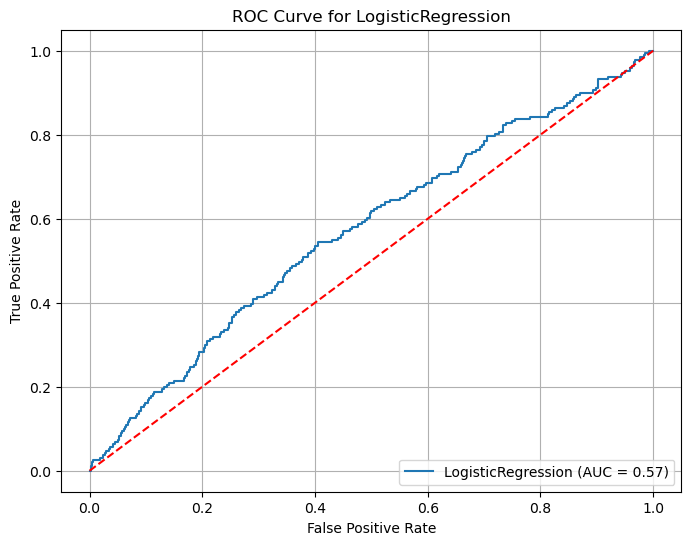

Decision Tree
Train Score: 1.0
Test Score: 0.8459399332591768
Confusion Matrix:
 [[3003  402]
 [ 152   39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92      3405
           1       0.09      0.20      0.12       191

    accuracy                           0.85      3596
   macro avg       0.52      0.54      0.52      3596
weighted avg       0.91      0.85      0.87      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

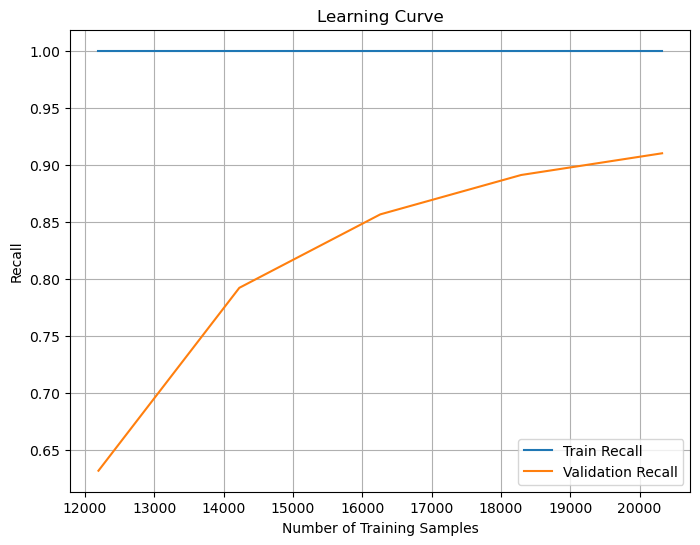

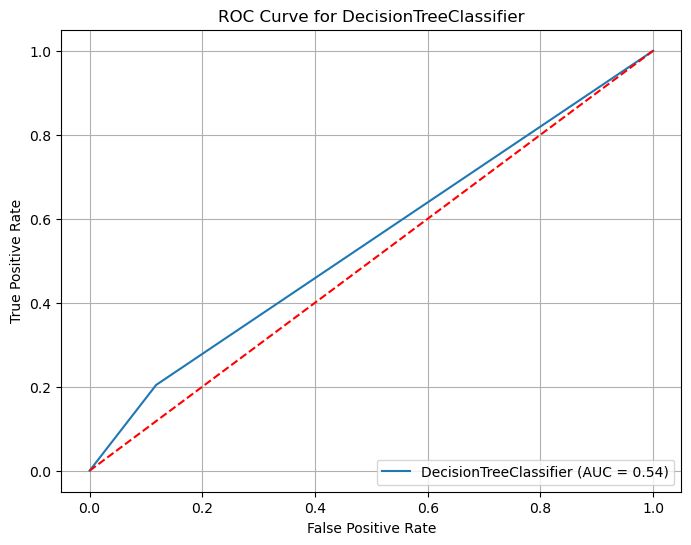

Random Forest
Train Score: 1.0
Test Score: 0.9154616240266963
Confusion Matrix:
 [[3280  125]
 [ 179   12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      3405
           1       0.09      0.06      0.07       191

    accuracy                           0.92      3596
   macro avg       0.52      0.51      0.51      3596
weighted avg       0.90      0.92      0.91      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

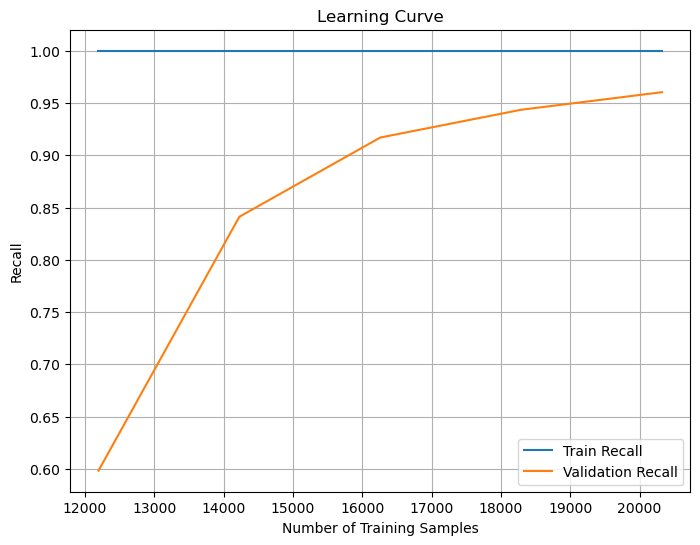

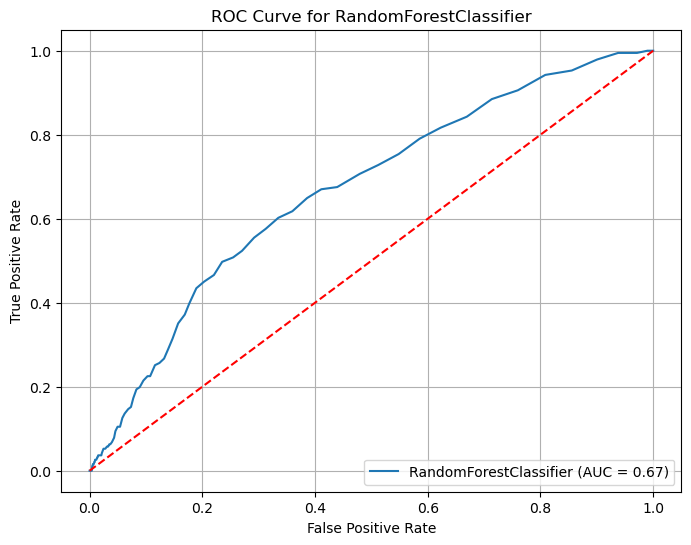

AdaBoost


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Score: 0.8243173431734317
Test Score: 0.8167408231368187
Confusion Matrix:
 [[2856  549]
 [ 110   81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      3405
           1       0.13      0.42      0.20       191

    accuracy                           0.82      3596
   macro avg       0.55      0.63      0.55      3596
weighted avg       0.92      0.82      0.86      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

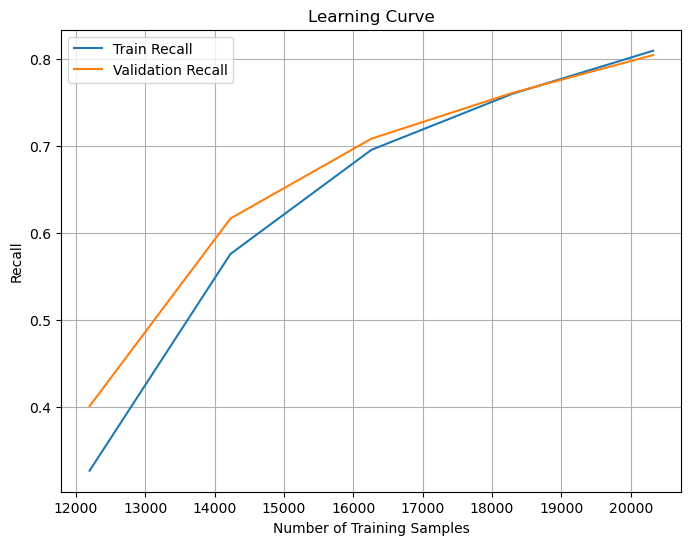

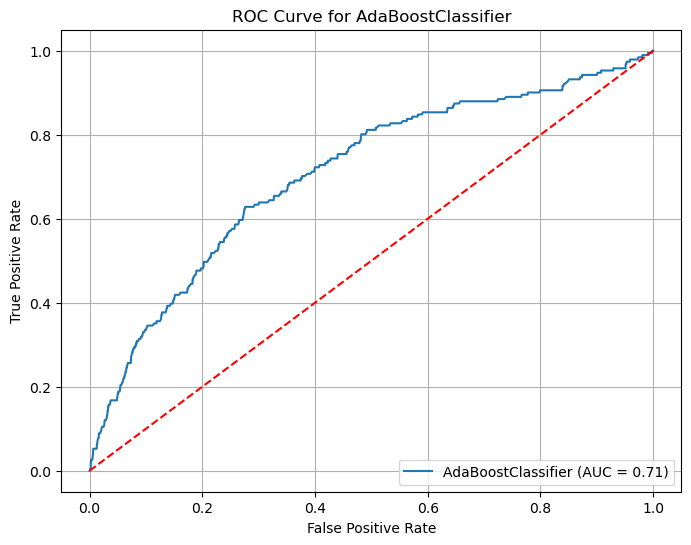

Support Vector Machine
Train Score: 0.856309963099631
Test Score: 0.7616796440489433
Confusion Matrix:
 [[2643  762]
 [  95   96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.78      0.86      3405
           1       0.11      0.50      0.18       191

    accuracy                           0.76      3596
   macro avg       0.54      0.64      0.52      3596
weighted avg       0.92      0.76      0.82      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(X

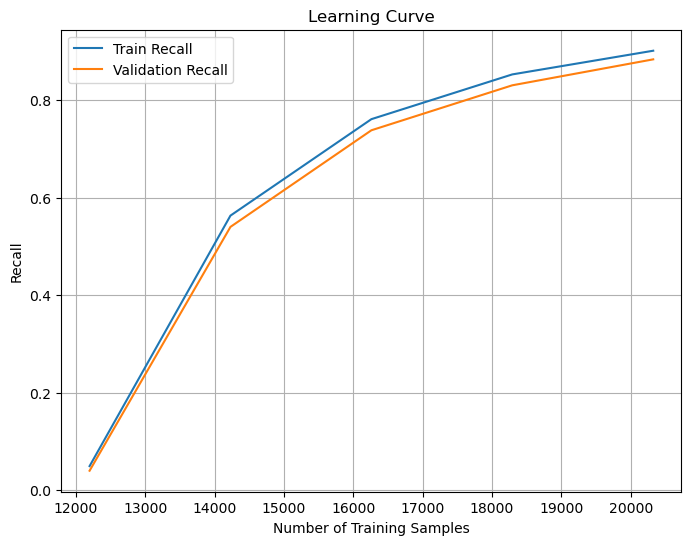

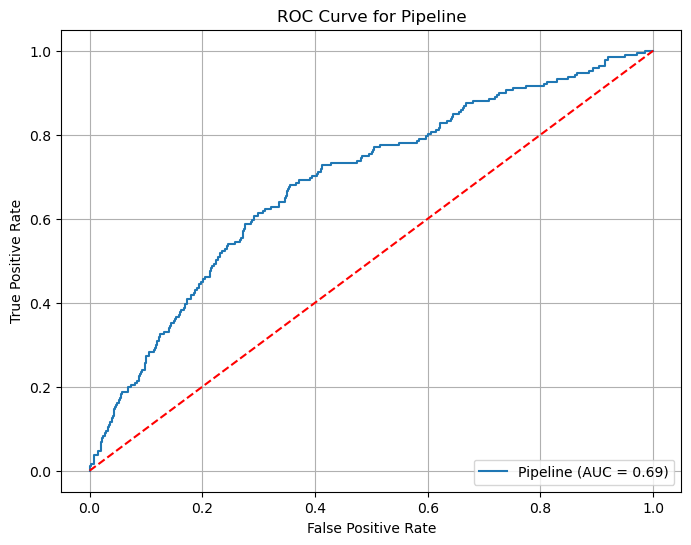

K-Nearest Neighbors
Train Score: 0.9032841328413285
Test Score: 0.7127363737486095
Confusion Matrix:
 [[2492  913]
 [ 120   71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.73      0.83      3405
           1       0.07      0.37      0.12       191

    accuracy                           0.71      3596
   macro avg       0.51      0.55      0.47      3596
weighted avg       0.91      0.71      0.79      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

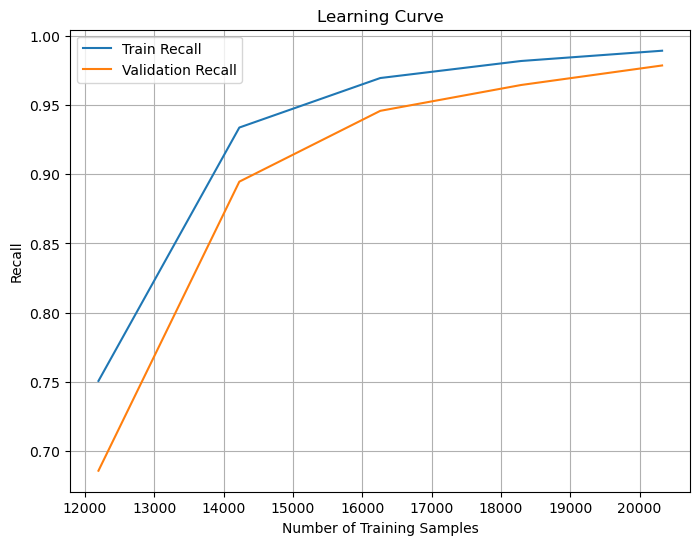

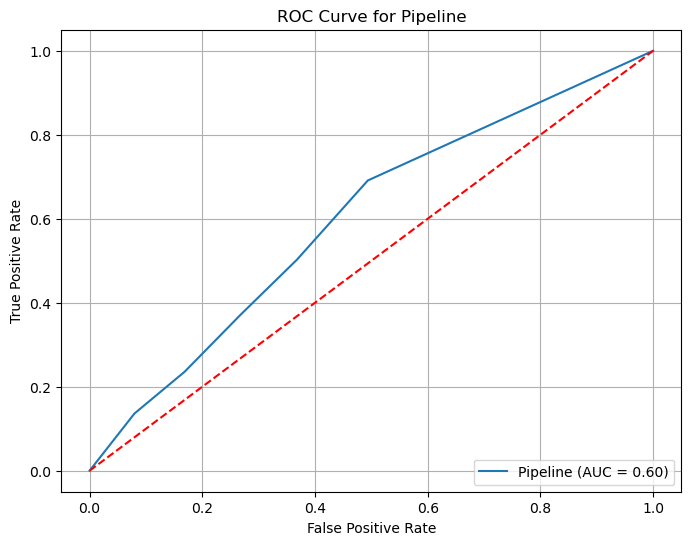

LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13550, number of negative: 13550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 27100, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train Score: 0.9283763837638377
Test Score: 0.8901557285873193
Confusion Matrix:
 [[3165  240]
 [ 155   36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3405
           1       0.13      0.19      0.15       191

    accuracy                           0.89      3596
   macro avg       0.54      0.56      0.55      3596
wei

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4065, number of negative: 10162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 14227, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285724 -> initscore=-0.916242
[LightGBM] [Info] Start training from score -0.916242
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6098, number of negative: 10162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10163, number of negative: 10162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 20325, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000098
[LightGBM] [Info] Start training from score 0.000098
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 137, number of negative: 1895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 595, number of negative: 9567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10162, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.058551 -> initscore=-2.777514
[LightGBM] [Info] Start training from score -2.777514
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2032, number of negative: 10163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

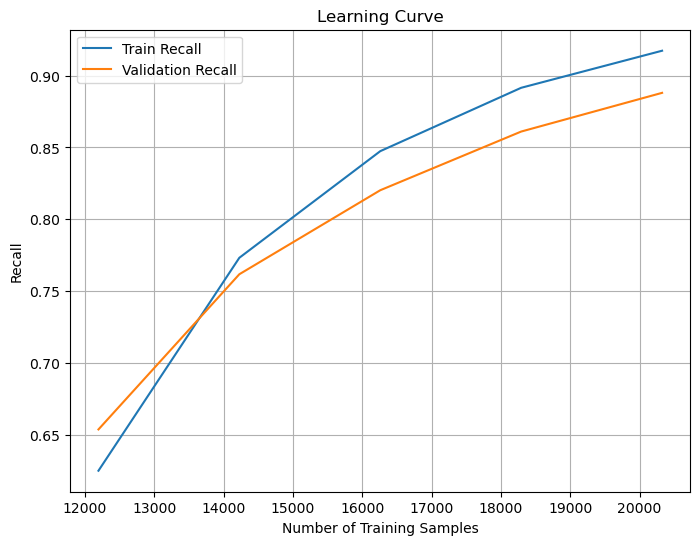

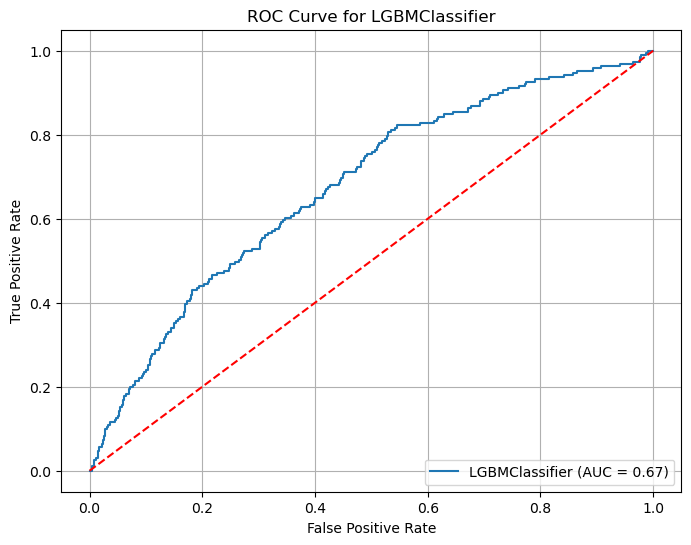

CatBoost
Train Score: 0.95619926199262
Test Score: 0.9040600667408232
Confusion Matrix:
 [[3223  182]
 [ 163   28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3405
           1       0.13      0.15      0.14       191

    accuracy                           0.90      3596
   macro avg       0.54      0.55      0.54      3596
weighted avg       0.91      0.90      0.91      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\Admin\anaconda3\Lib\site-packages\catboost\core.py", line 2400, in 

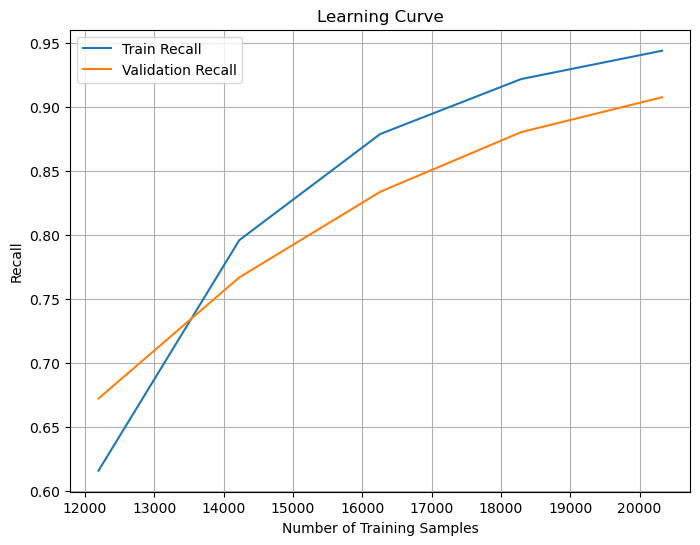

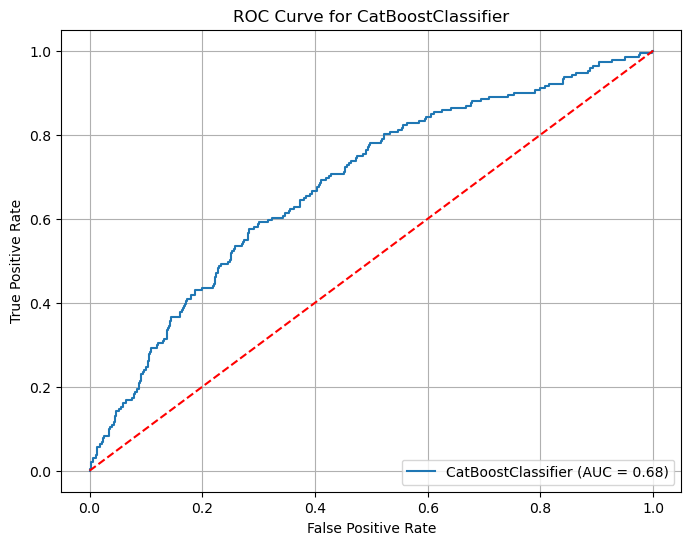

XGBoost
Train Score: 0.9619557195571956
Test Score: 0.8898776418242491
Confusion Matrix:
 [[3173  232]
 [ 164   27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3405
           1       0.10      0.14      0.12       191

    accuracy                           0.89      3596
   macro avg       0.53      0.54      0.53      3596
weighted avg       0.91      0.89      0.90      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

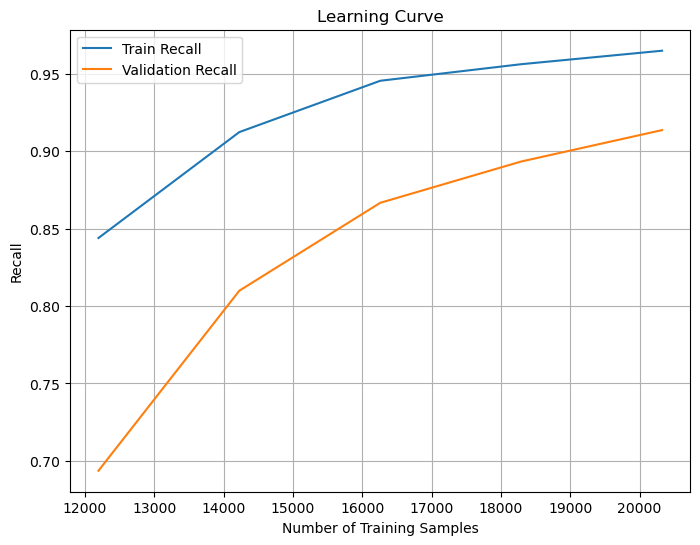

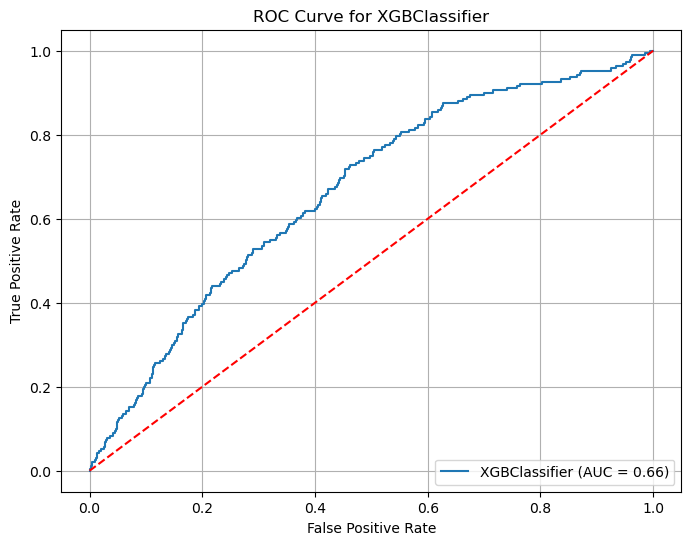

In [16]:
# Evaluate each model
for name, model in models.items():
    print(name)
    evaluation(model)

In [17]:
# Create a DataFrame with the results
performance_df = pd.DataFrame(performance_summary)

# Display the performance summary
print(performance_df)

                    Model  Accuracy  Precision    Recall  F1 Score       AUC
0      LogisticRegression  0.560623   0.065666  0.549738  0.117318  0.571379
1  DecisionTreeClassifier  0.845940   0.088435  0.204188  0.123418  0.543063
2  RandomForestClassifier  0.915462   0.087591  0.062827  0.073171  0.668184
3      AdaBoostClassifier  0.816741   0.128571  0.424084  0.197320  0.707839
4                Pipeline  0.761680   0.111888  0.502618  0.183031  0.687505
5                Pipeline  0.712736   0.072154  0.371728  0.120851  0.598980
6          LGBMClassifier  0.890156   0.130435  0.188482  0.154176  0.674958
7      CatBoostClassifier  0.904060   0.133333  0.146597  0.139651  0.681897
8           XGBClassifier  0.889878   0.104247  0.141361  0.120000  0.664659


# Vesion 4: Basic model with the SMOTE method and balanced classes

In [18]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(random_state=0, probability=True, class_weight='balanced')),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
}

# Dictionary to store performance metrics
performance_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': []
}

def evaluation(model):
    result = model.fit(X_train_smote, y_train_smote)
    y_pred = result.predict(X_test)
    
    # Display model scores
    train_score = result.score(X_train_smote, y_train_smote)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)

    # Display confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Compute learning curves with recall for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train_smote, y_train_smote, cv=4, scoring='recall', train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(N, train_score.mean(axis=1), label='Train Recall')
    plt.plot(N, val_score.mean(axis=1), label='Validation Recall')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Recall')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute ROC AUC score and plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Add performance metrics to the summary
    performance_summary['Model'].append(model.__class__.__name__)
    performance_summary['Accuracy'].append(accuracy)
    performance_summary['Precision'].append(precision)
    performance_summary['Recall'].append(recall)
    performance_summary['F1 Score'].append(f1)
    performance_summary['AUC'].append(roc_auc)

Logistic Regression
Train Score: 0.6248708487084871
Test Score: 0.560622914349277
Confusion Matrix:
 [[1911 1494]
 [  86  105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.56      0.71      3405
           1       0.07      0.55      0.12       191

    accuracy                           0.56      3596
   macro avg       0.51      0.56      0.41      3596
weighted avg       0.91      0.56      0.68      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1246, in fit
    raise ValueE

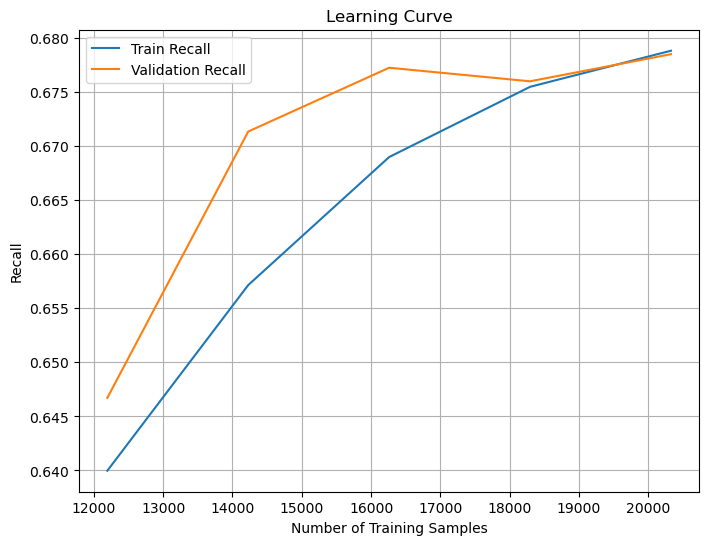

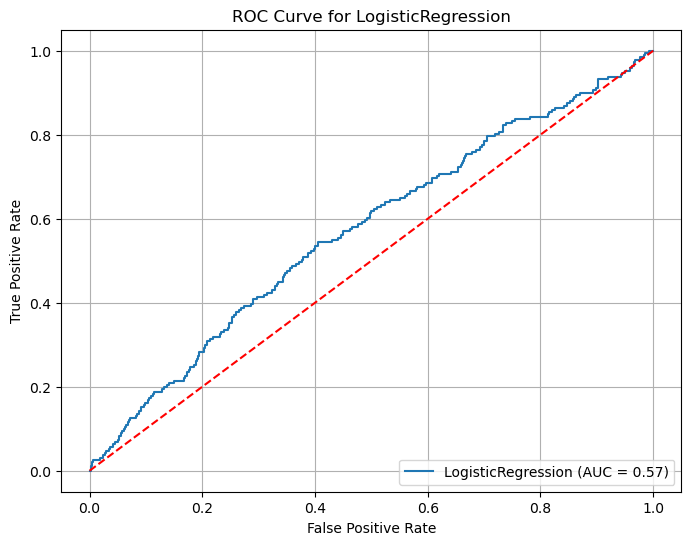

Decision Tree
Train Score: 1.0
Test Score: 0.8459399332591768
Confusion Matrix:
 [[3003  402]
 [ 152   39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92      3405
           1       0.09      0.20      0.12       191

    accuracy                           0.85      3596
   macro avg       0.52      0.54      0.52      3596
weighted avg       0.91      0.85      0.87      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

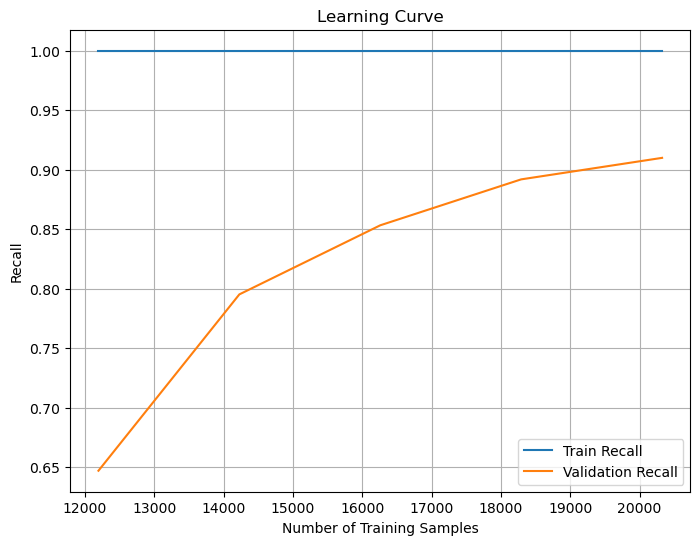

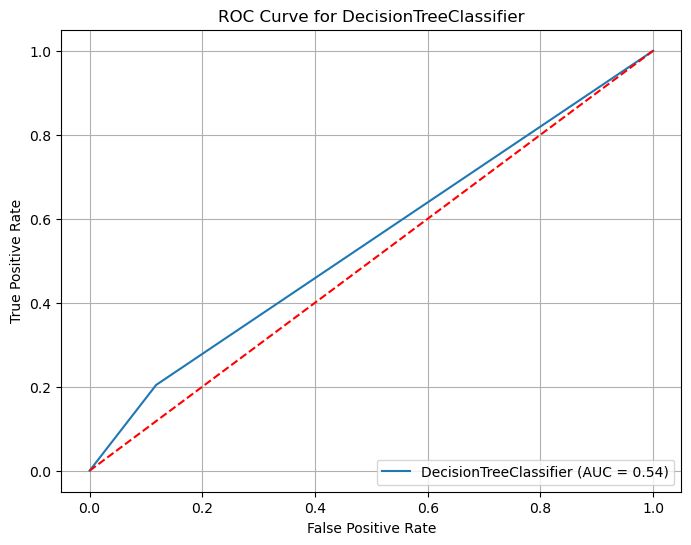

Random Forest
Train Score: 1.0
Test Score: 0.9154616240266963
Confusion Matrix:
 [[3280  125]
 [ 179   12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      3405
           1       0.09      0.06      0.07       191

    accuracy                           0.92      3596
   macro avg       0.52      0.51      0.51      3596
weighted avg       0.90      0.92      0.91      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

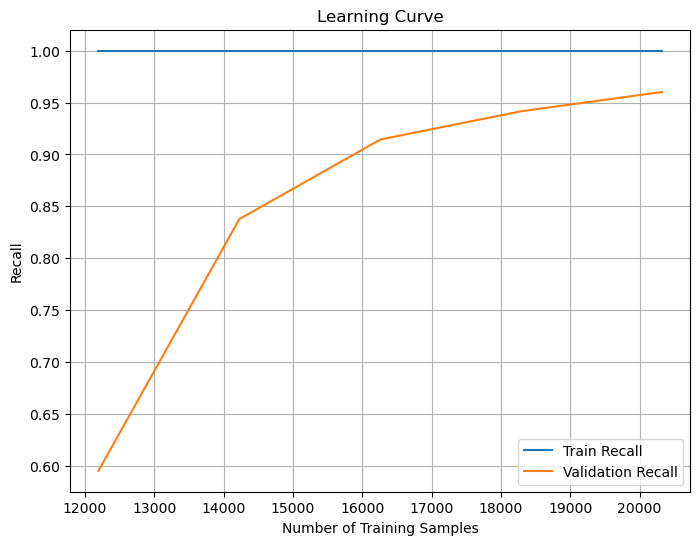

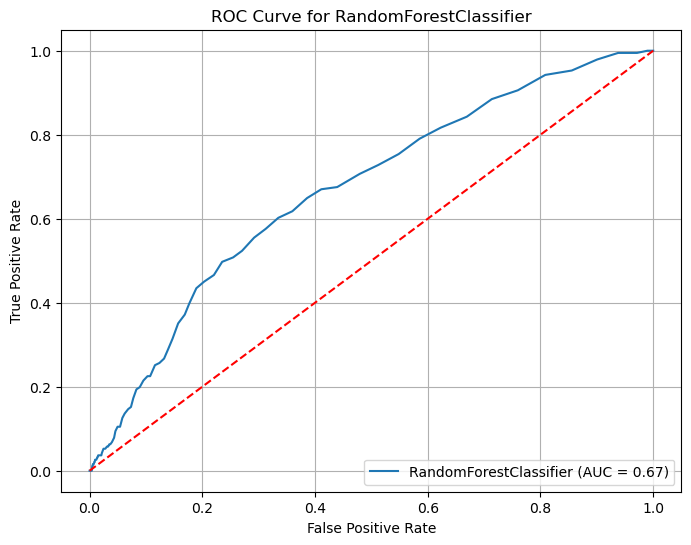

AdaBoost


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Score: 0.8243173431734317
Test Score: 0.8167408231368187
Confusion Matrix:
 [[2856  549]
 [ 110   81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      3405
           1       0.13      0.42      0.20       191

    accuracy                           0.82      3596
   macro avg       0.55      0.63      0.55      3596
weighted avg       0.92      0.82      0.86      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Adm

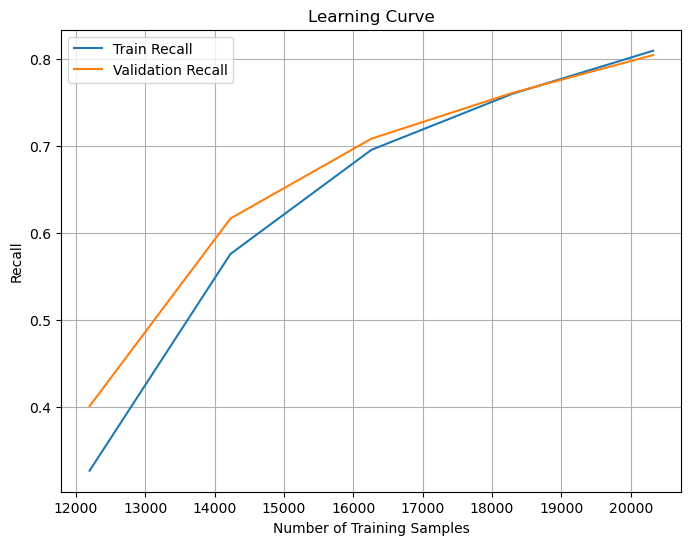

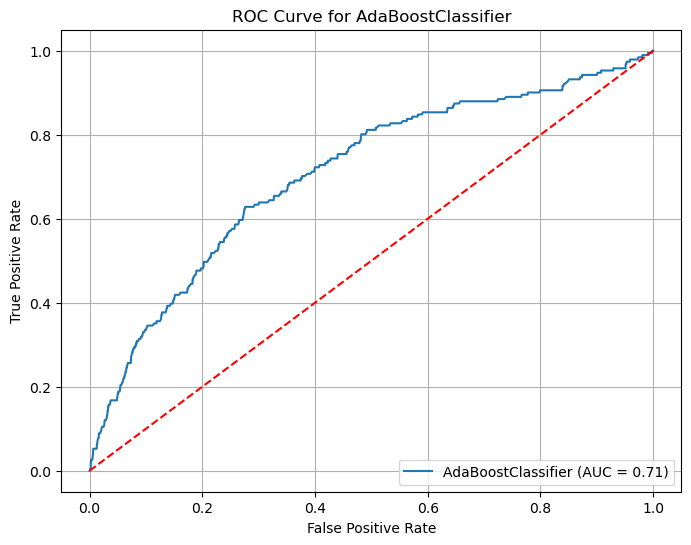

Support Vector Machine
Train Score: 0.856309963099631
Test Score: 0.7616796440489433
Confusion Matrix:
 [[2643  762]
 [  95   96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.78      0.86      3405
           1       0.11      0.50      0.18       191

    accuracy                           0.76      3596
   macro avg       0.54      0.64      0.52      3596
weighted avg       0.92      0.76      0.82      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(X

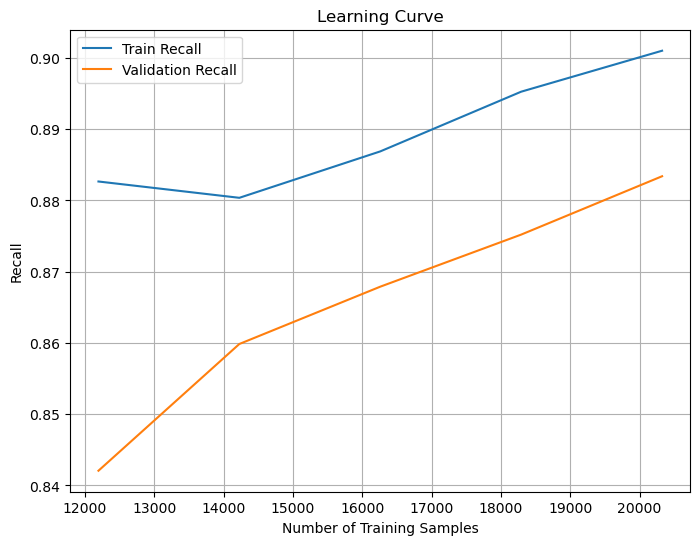

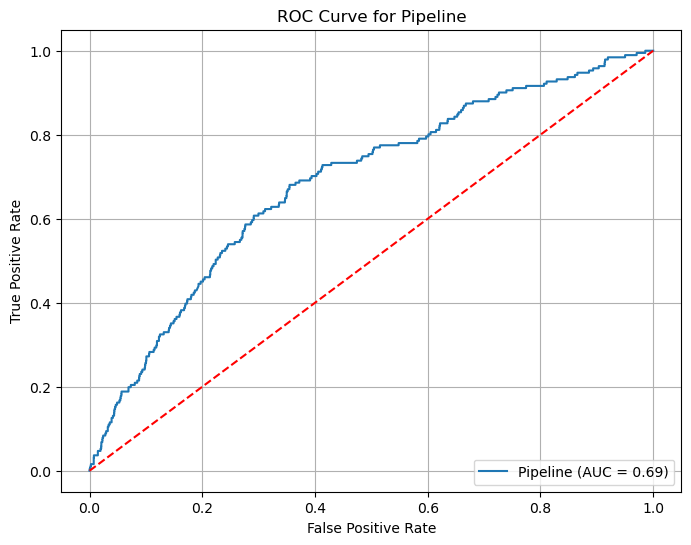

K-Nearest Neighbors
Train Score: 0.9032841328413285
Test Score: 0.7127363737486095
Confusion Matrix:
 [[2492  913]
 [ 120   71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.73      0.83      3405
           1       0.07      0.37      0.12       191

    accuracy                           0.71      3596
   macro avg       0.51      0.55      0.47      3596
weighted avg       0.91      0.71      0.79      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

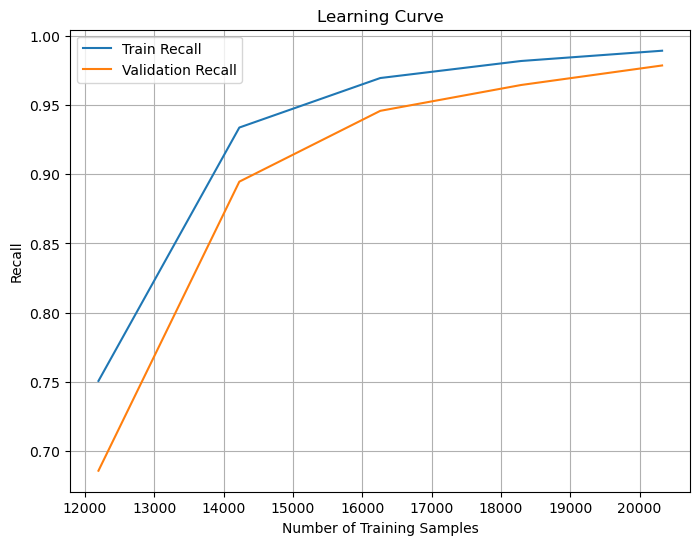

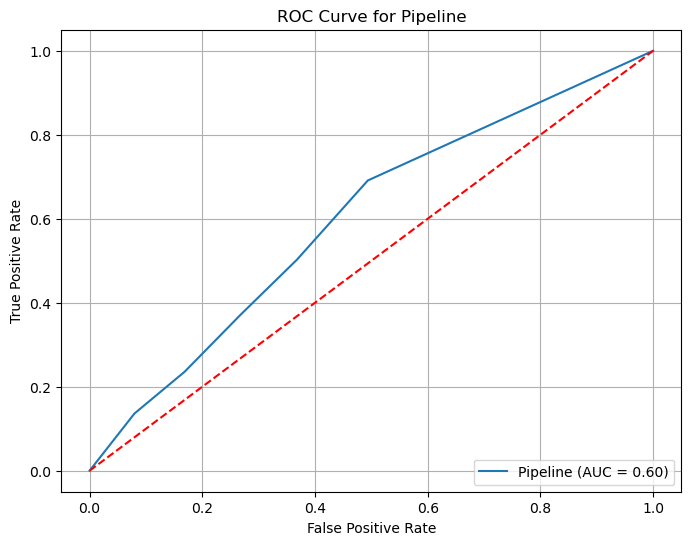

LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13550, number of negative: 13550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 27100, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train Score: 0.9283763837638377
Test Score: 0.8901557285873193
Confusion Matrix:
 [[3165  240]
 [ 155   36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3405
           1       0.13      0.19      0.15       191

    accuracy                           0.89      3596
   macro avg       0.54      0.56      0.55      3596
wei

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4065, number of negative: 10162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 14227, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6098, number of negative: 10162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 137, number of negative: 1895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 246, number of negative: 3819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Numb

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 595, number of negative: 9567
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10162, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2032, number of negative: 10163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

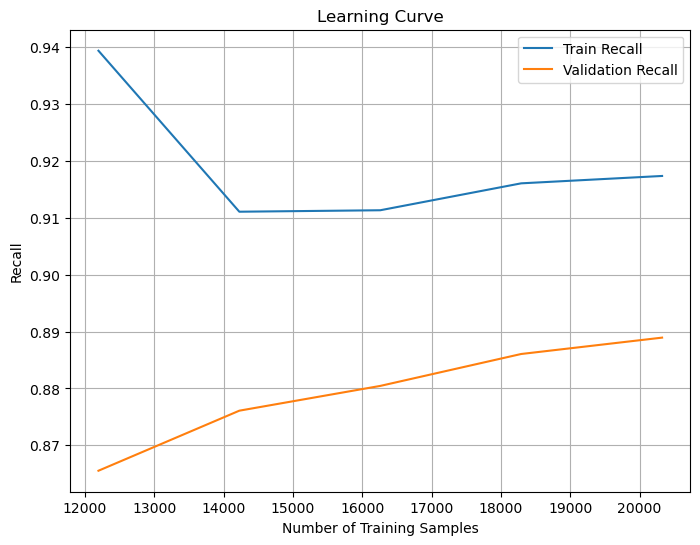

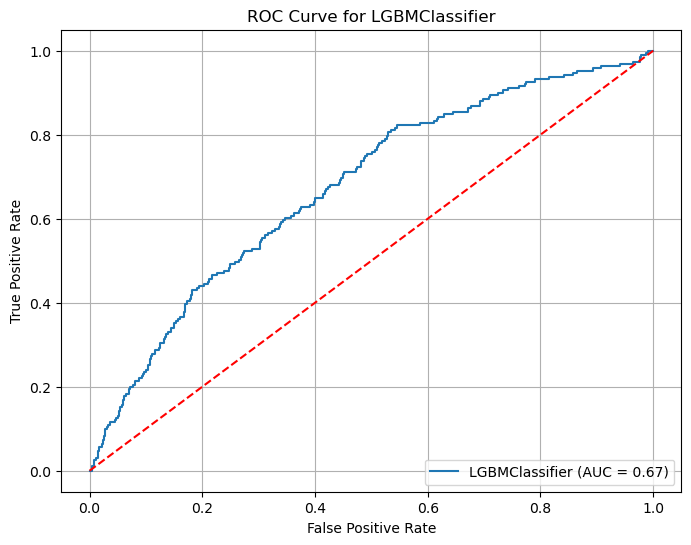

CatBoost
Train Score: 0.95619926199262
Test Score: 0.9040600667408232
Confusion Matrix:
 [[3223  182]
 [ 163   28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3405
           1       0.13      0.15      0.14       191

    accuracy                           0.90      3596
   macro avg       0.54      0.55      0.54      3596
weighted avg       0.91      0.90      0.91      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\Admin\anaconda3\Lib\site-packages\catboost\core.py", line 2400, in 

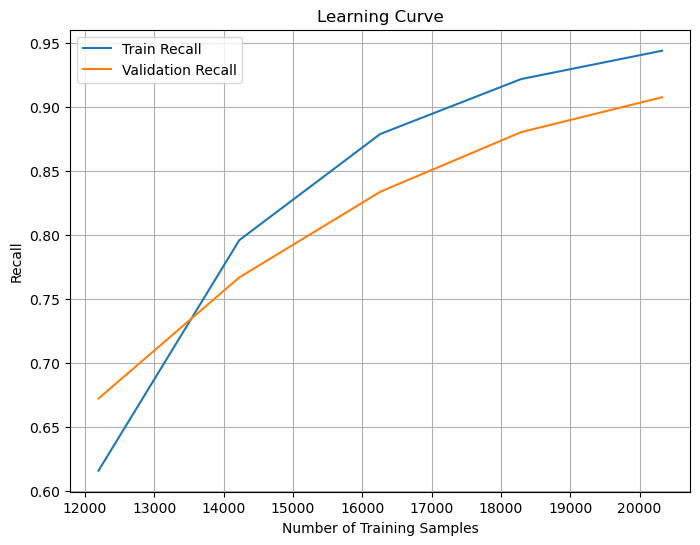

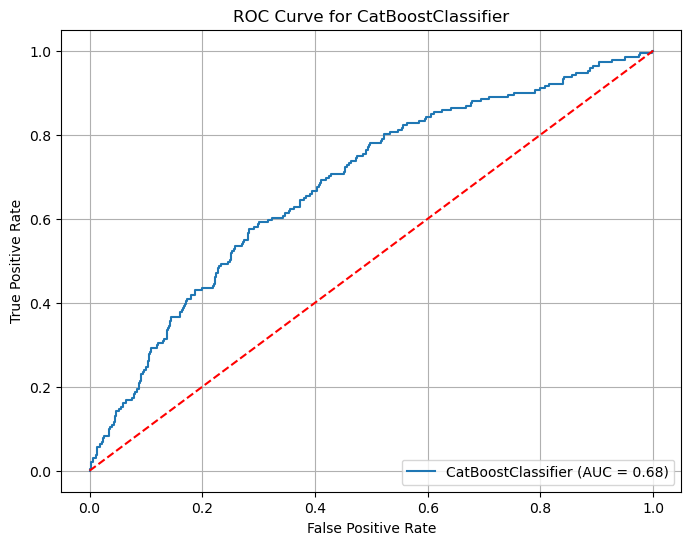

XGBoost
Train Score: 0.8929151291512916
Test Score: 0.7185761957730812
Confusion Matrix:
 [[2499  906]
 [ 106   85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.73      0.83      3405
           1       0.09      0.45      0.14       191

    accuracy                           0.72      3596
   macro avg       0.52      0.59      0.49      3596
weighted avg       0.91      0.72      0.80      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _

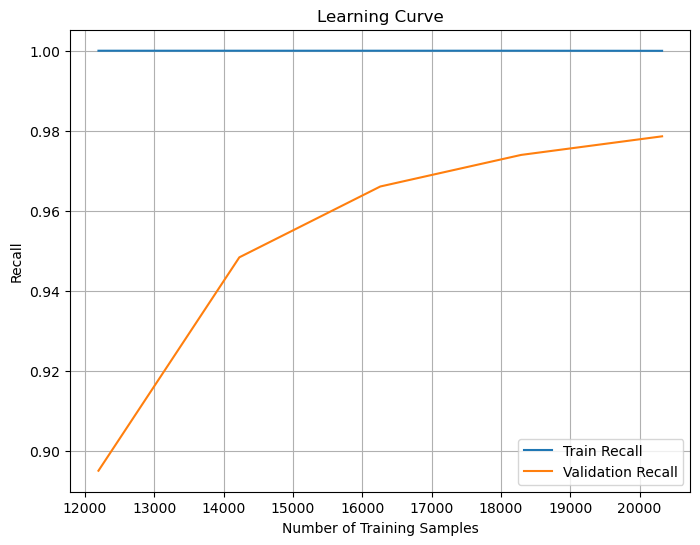

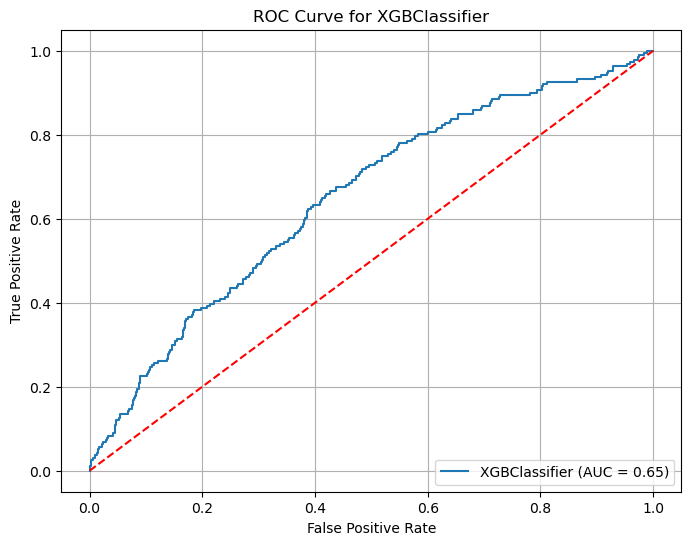

In [19]:
# Evaluate each model
for name, model in models.items():
    print(name)
    evaluation(model)

In [20]:
# Create a DataFrame with the results
performance_df = pd.DataFrame(performance_summary)

# Display the performance summary
print(performance_df)

                    Model  Accuracy  Precision    Recall  F1 Score       AUC
0      LogisticRegression  0.560623   0.065666  0.549738  0.117318  0.571379
1  DecisionTreeClassifier  0.845940   0.088435  0.204188  0.123418  0.543063
2  RandomForestClassifier  0.915462   0.087591  0.062827  0.073171  0.668184
3      AdaBoostClassifier  0.816741   0.128571  0.424084  0.197320  0.707839
4                Pipeline  0.761680   0.111888  0.502618  0.183031  0.687477
5                Pipeline  0.712736   0.072154  0.371728  0.120851  0.598980
6          LGBMClassifier  0.890156   0.130435  0.188482  0.154176  0.674958
7      CatBoostClassifier  0.904060   0.133333  0.146597  0.139651  0.681897
8           XGBClassifier  0.718576   0.085772  0.445026  0.143824  0.648075


## interpretation:

After analyzing the results obtained in the 4 versions, and depending on the performance of their "recall" and their "f1score" I decided to focus more on version 2 in which the weight of each class was balance. Here are the 4 models selected to attempt optimization:


Logistic Regression (Version 2):
Recall = 0.654450, F1 Score = 0.143843

Support Vector Machine (Pipeline) (Versions 2):
Recall = 0.612565, F1 Score = 0.175940

LightGBM (Version 2): 
Recall = 0.481675, F1 Score = 0.200436

XGBoost (Version 2):
Recall = 0.193717, F1 Score = 0.149194